In [4]:
# ============================================================
# 💡 Warum nutzen wir den CLOSE-Preis als Hauptsignal?
# ============================================================

# 1) Der Close-Preis ist der wichtigste Referenzpreis im Trading.
#    → Er zeigt den endgültigen Preis eines Tages nach allen Käufen/Verkäufen.
#    → Analysten, Banken, Algorithmen arbeiten fast immer mit Close-Daten.

# 2) Der Close-Preis ist stabiler und weniger zufällig als Open/High/Low.
#    → Der Open-Preis kann stark verzerrt sein (Gaps, News, Übernacht-Volatilität).
#    → High/Low zeigen nur Extrempunkte und sind für ML schlecht geeignet.
#    → Der Close fasst den gesamten Handelstag „zusammen“.

# 3) Technische Indikatoren basieren auf dem Close.
#    → Moving Averages (MA7, MA21, MA50, MA200)
#    → Momentum
#    → Volatility
#    → Returns
#    Fast alle dieser Features nutzen den Schlusskurs.

# 4) Maschinenlernmodelle brauchen ein klares Ziel.
#    Unser Ziel ist: "Steigt Bitcoin morgen?"
#    Dafür müssen wir wissen:
#    - Close(t) = heutiger Schlusskurs
#    - Close(t+1) = morgiger Schlusskurs
#    → Dadurch können wir die Richtung (steigt/fällt) mathematisch korrekt bestimmen.

# 5) Close-Preis wird weltweit als Standard für Backtesting genutzt.
#    → Professionelle Trader
#    → Hedgefonds
#    → Universitäten
#    → Kaggle-Challenges
#    Alle verwenden den Schlusskurs, weil er objektiv & vergleichbar ist.


In [9]:
# ============================================================
# 0) Technische Features berechnen, bevor wir Zielvariablen erzeugen
# ============================================================

# Daily Returns (prozentuale Tagesänderung)
df["Return"] = df["Close"].pct_change()                    # Kommentar: (Close_t - Close_t-1) / Close_t-1

# Gleitende Durchschnitte
df["MA7"] = df["Close"].rolling(window=7).mean()           # Kommentar: Durchschnitt der letzten 7 Tage
df["MA21"] = df["Close"].rolling(window=21).mean()         # Kommentar: Durchschnitt der letzten 21 Tage
df["MA50"] = df["Close"].rolling(window=50).mean()         # Kommentar: Durchschnitt der letzten 50 Tage
df["MA200"] = df["Close"].rolling(window=200).mean()       # Kommentar: Durchschnitt der letzten 200 Tage

# Volatilität (Standardabweichung über 30 Tage)
df["Volatility30"] = df["Return"].rolling(window=30).std() # Kommentar: Schwankung über die letzten 30 Tage

# Momentum (Preis heute minus Preis vor 7 Tagen)
df["Momentum7"] = df["Close"] - df["Close"].shift(7)       # Kommentar: Momentumfaktor: wie viel ist Preis hoch/runter gegangen in 7 Tagen

print("\n🔧 Technische Features berechnet:")
print(df.head(15))



🔧 Technische Features berechnet:
         Date        Open        High         Low       Close    Volume  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   
5  2014-09-22  399.100006  406.915985  397.130005  402.152008  24127600   
6  2014-09-23  402.092010  441.557007  396.196991  435.790985  45099500   
7  2014-09-24  435.751007  436.112000  421.131989  423.204987  30627700   
8  2014-09-25  423.156006  423.519989  409.467987  411.574005  26814400   
9  2014-09-26  411.428986  414.937988  400.009003  404.424988  21460800   
10 2014-09-27  403.556000  406.622986  397.372009  399.519989  15029300   
11 2014-09-28  399.471008  401.016998  374.332001  377.181000  236

In [11]:
# ============================================================
# 1) Zielvariablen für mehrere Zeithorizonte (ohne 10 Jahre)
#    Wir berechnen zukünftige Preise & Veränderungen
# ============================================================

# Wir definieren verschiedene Vorhersage-Horizonte:
# - 1 Tag
# - 7 Tage
# - 30 Tage (~1 Monat)
# - 90 Tage (~3 Monate)
# - 182 Tage (~halbes Jahr)
# - 365 Tage (~1 Jahr)

horizons = {
    "1d": 1,            # Kommentar: 1 Tag in die Zukunft
    "7d": 7,            # Kommentar: 7 Tage in die Zukunft
    "30d": 30,          # Kommentar: 30 Tage in die Zukunft
    "90d": 90,          # Kommentar: 90 Tage in die Zukunft
    "182d": 182,        # Kommentar: 182 Tage (~6 Monate) in die Zukunft
    "365d": 365         # Kommentar: 365 Tage (~1 Jahr) in die Zukunft
}


# --- 1a) zukünftige Preise & Veränderungen berechnen ---
for name, days in horizons.items():                         # Kommentar: über jeden Zeithorizont in horizons iterieren
    
    df[f"Close_{name}"] = df["Close"].shift(-days)          # Kommentar: zukünftiger Schlusskurs in X Tagen
    
    df[f"Change_{name}_abs"] = df[f"Close_{name}"] - df["Close"]   # Kommentar: absolute Veränderung = zukünftiger Preis - heutiger Preis
    
    df[f"Change_{name}_pct"] = (df[f"Close_{name}"] - df["Close"]) / df["Close"]  # Kommentar: prozentuale Veränderung relativ zu heute


# --- 1b) Spezielle Spalte für "Preis von morgen" ---
df["Close_tmr"] = df["Close_1d"]                            # Kommentar: Close_tmr als Alias für "Preis in 1 Tag"


# --- 1c) Vorschau der neuen Spalten (vor Dropna) ---
preview_cols = (
    ["Date", "Close", "Close_tmr"] +                        # Kommentar: Grundspalten
    [f"Close_{k}" for k in horizons.keys()] +               # Kommentar: alle zukünftigen Preise
    [f"Change_{k}_abs" for k in horizons.keys()] +          # Kommentar: alle absoluten Veränderungen
    [f"Change_{k}_pct" for k in horizons.keys()]            # Kommentar: alle prozentualen Veränderungen
)

print("\n🔍 Vorschau der Zielvariablen (vor Dropna):")       # Kommentar: Überschrift für die Vorschau
print(df[preview_cols].head(15))                            # Kommentar: erste 15 Zeilen mit allen Zielvariablen anzeigen


# --- 1d) Zeilen ohne Zukunftsdaten entfernen ---
# Am Ende der Zeitreihe gibt es keine Zukunftsdaten mehr für die letzten Tage,
# deswegen entstehen dort NaN-Werte in den Close_XX-Spalten.                     # Kommentar: Erklärung für NaNs

df = df.dropna(subset=[f"Close_{k}" for k in horizons.keys()])      # Kommentar: alle Zeilen löschen, bei denen mindestens ein Close_XX NaN ist

print("\n✅ Nach Dropna auf Zukunftsspalten:")              # Kommentar: Hinweis, dass Dropna durchgeführt wurde
print("Shape nach Dropna:", df.shape)                      # Kommentar: neue Zeilen-/Spaltenanzahl anzeigen
print(df[preview_cols].head(10))                           # Kommentar: erste 10 Zeilen nach Dropna zur Kontrolle ausgeben



🔍 Vorschau der Zielvariablen (vor Dropna):
         Date       Close   Close_tmr    Close_1d    Close_7d   Close_30d  \
0  2014-09-17  457.334015  424.440002  424.440002  423.204987  383.757996   
1  2014-09-18  424.440002  394.795990  394.795990  411.574005  391.441986   
2  2014-09-19  394.795990  408.903992  408.903992  404.424988  389.545990   
3  2014-09-20  408.903992  398.821014  398.821014  399.519989  382.845001   
4  2014-09-21  398.821014  402.152008  402.152008  377.181000  386.475006   
5  2014-09-22  402.152008  435.790985  435.790985  375.467010  383.157990   
6  2014-09-23  435.790985  423.204987  423.204987  386.944000  358.416992   
7  2014-09-24  423.204987  411.574005  411.574005  383.614990  358.345001   
8  2014-09-25  411.574005  404.424988  404.424988  375.071991  347.270996   
9  2014-09-26  404.424988  399.519989  399.519989  359.511993  354.704010   
10 2014-09-27  399.519989  377.181000  377.181000  328.865997  352.989014   
11 2014-09-28  377.181000  375.4

In [12]:
# ============================================================
# 2) Features auswählen + df_model vorbereiten + Zeitreihen-Split
# ============================================================

# -----------------------------
# 2.1) Feature-Spalten definieren
# -----------------------------
# Wir nutzen NUR historische Informationen – KEINE Zukunftsspalten!

exclude_cols = []                                        # Kommentar: Liste der auszuschließenden Spalten
exclude_cols.append("Date")                              # Kommentar: Datum wird nicht direkt als numerisches Feature genutzt
exclude_cols.append("Close_tmr")                         # Kommentar: Zielvariable -> darf nicht Feature sein

# Alle Zukunfts-Spalten entfernen: Close_XXd + Change_XXd
exclude_cols += [c for c in df.columns if c.startswith("Close_")]   # Kommentar: alle Close_1d, Close_7d, ...
exclude_cols += [c for c in df.columns if c.startswith("Change_")]  # Kommentar: alle Change_1d_abs, Change_7d_pct, ...

# Feature-Liste erstellen
feature_cols = [c for c in df.columns if c not in exclude_cols]     # Kommentar: alle anderen Spalten sind Features

print("\n📌 Verwendete Feature-Spalten (X):")
print(feature_cols)


# -----------------------------
# 2.2) df_model vorbereiten: NaNs in Features entfernen
# -----------------------------
# Wegen MA200, Volatility30 etc. haben die ersten 200 Zeilen NaN
# Deshalb: vollständige Zeilen behalten

df_model = df.dropna(subset=feature_cols + ["Close_tmr"])           # Kommentar: nur Zeilen behalten mit vollständigen Daten

print("\n✅ df_model Shape (nach Entfernen von NaNs):", df_model.shape)


# -----------------------------
# 2.3) X und y definieren
# -----------------------------
X = df_model[feature_cols].copy()                                   # Kommentar: Feature-Matrix X
y = df_model["Close_tmr"].copy()                                    # Kommentar: Zielvariable y


# -----------------------------
# 2.4) Zeitreihen-gerechter Train/Test-Split
# -----------------------------
split_index = int(len(df_model) * 0.8)                              # Kommentar: 80% Training, 20% Test – ohne Shuffle!

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

print("\n🧪 Train/Test-Split erfolgreich:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)



📌 Verwendete Feature-Spalten (X):
['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7', 'MA21', 'MA50', 'MA200', 'Volatility30', 'Momentum7']

✅ df_model Shape (nach Entfernen von NaNs): (3161, 32)

🧪 Train/Test-Split erfolgreich:
X_train: (2528, 12)
X_test : (633, 12)
y_train: (2528,)
y_test : (633,)



📊 Ergebnisse für: Naive (Close_t ≈ Close_t+1)
  MSE  : 571,020.51
  RMSE : 755.66
  MAE  : 489.14
  R²   : 0.9884

📊 Ergebnisse für: Lineare Regression
  MSE  : 581,276.02
  RMSE : 762.41
  MAE  : 498.95
  R²   : 0.9882

📊 Ergebnisse für: Random Forest
  MSE  : 8,063,831.31
  RMSE : 2,839.69
  MAE  : 2,527.58
  R²   : 0.8366

🏁 Modellvergleich (nach RMSE sortiert):
               Modell           mse         rmse          mae        r2
0     Naive (Close_t)  5.710205e+05   755.658989   489.139928  0.988431
1  Lineare Regression  5.812760e+05   762.414601   498.945928  0.988223
2       Random Forest  8.063831e+06  2839.688594  2527.580006  0.836619


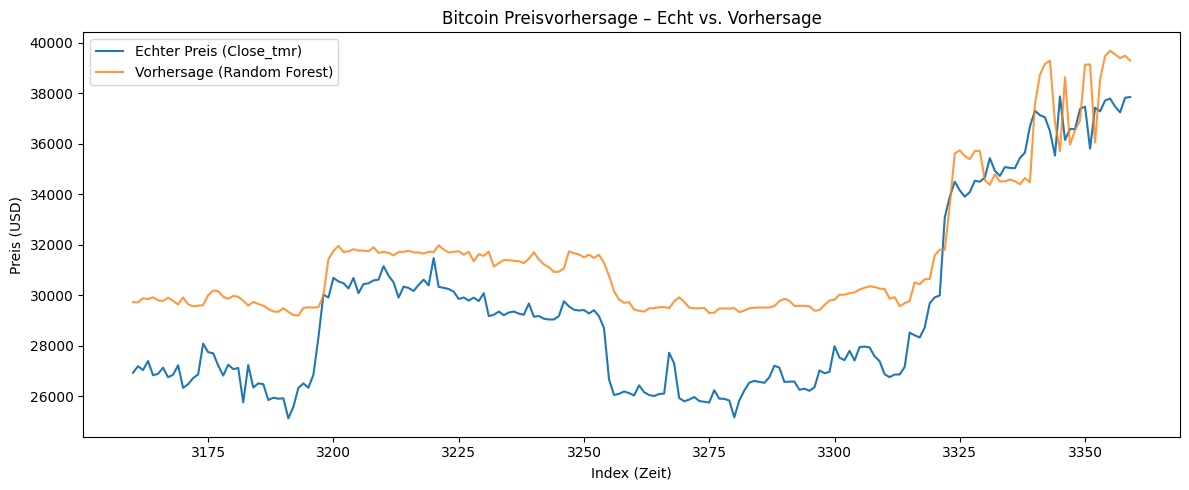

In [13]:
# ============================================================
# 3) Modelle trainieren und evaluieren (1-Tages-Vorhersage)
# ============================================================

# -----------------------------
# 3.1) Skalierer importieren
# -----------------------------
from sklearn.preprocessing import StandardScaler           # Kommentar: Für lineare Modelle nützlich
from sklearn.linear_model import LinearRegression          # Kommentar: Lineare Regression für baseline-ML
from sklearn.ensemble import RandomForestRegressor         # Kommentar: Leistungsstarkes Ensemble-Modell
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Kommentar: Bewertungsmetriken


# -----------------------------
# 3.2) Features skalieren (für Linear Regression sinnvoll)
# -----------------------------
scaler = StandardScaler()                                  # Kommentar: Skalierer erstellen

X_train_scaled = scaler.fit_transform(X_train)             # Kommentar: Trainingsdaten fitten & transformieren
X_test_scaled  = scaler.transform(X_test)                  # Kommentar: Testdaten transformieren (gleiche Skala)


# -----------------------------
# 3.3) Hilfsfunktion zur Auswertung
# -----------------------------
def evaluate_regression(y_true, y_pred, name="Modell"):     # Kommentar: Funktion für Metriken
    mse = mean_squared_error(y_true, y_pred)                # Kommentar: Mittlerer quadratischer Fehler
    rmse = mse ** 0.5                                       # Kommentar: Wurzel davon = RMSE
    mae = mean_absolute_error(y_true, y_pred)               # Kommentar: mittlerer absoluter Fehler
    r2 = r2_score(y_true, y_pred)                           # Kommentar: R² = erklärte Varianz

    print(f"\n📊 Ergebnisse für: {name}")
    print(f"  MSE  : {mse:,.2f}")
    print(f"  RMSE : {rmse:,.2f}")
    print(f"  MAE  : {mae:,.2f}")
    print(f"  R²   : {r2:,.4f}")

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


# -----------------------------
# 3.4) Naives Modell: „Morgen ≈ Heute“
# -----------------------------
y_pred_naive = X_test["Close"].values                       # Kommentar: heutiger Schlusskurs = Vorhersage für morgen

metrics_naive = evaluate_regression(
    y_test, y_pred_naive,
    name="Naive (Close_t ≈ Close_t+1)"
)


# -----------------------------
# 3.5) Lineare Regression
# -----------------------------
lin_reg = LinearRegression()                                # Kommentar: Modell erzeugen
lin_reg.fit(X_train_scaled, y_train)                        # Kommentar: Training durchführen

y_pred_lin = lin_reg.predict(X_test_scaled)                 # Kommentar: Vorhersage auf Testdaten

metrics_lin = evaluate_regression(
    y_test, y_pred_lin,
    name="Lineare Regression"
)


# -----------------------------
# 3.6) Random Forest Regressor
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=300,                                       # Kommentar: 300 Bäume
    max_depth=None,                                         # Kommentar: Tiefe wird automatisch gewählt
    random_state=42,                                        # Kommentar: reproduzierbar
    n_jobs=-1                                               # Kommentar: alle Kerne nutzen
)

rf.fit(X_train, y_train)                                    # Kommentar: Random Forest ohne Skalierung trainieren

y_pred_rf = rf.predict(X_test)                              # Kommentar: Vorhersage auf Testdaten

metrics_rf = evaluate_regression(
    y_test, y_pred_rf,
    name="Random Forest"
)


# -----------------------------
# 3.7) Modellvergleich als Tabelle
# -----------------------------
results = pd.DataFrame([
    {"Modell": "Naive (Close_t)", **metrics_naive},
    {"Modell": "Lineare Regression", **metrics_lin},
    {"Modell": "Random Forest", **metrics_rf},
])

print("\n🏁 Modellvergleich (nach RMSE sortiert):")
print(results.sort_values("rmse"))                          # Kommentar: Beste Modelle oben


# -----------------------------
# 3.8) Plot: echte vs. vorhergesagte Preise
# -----------------------------
import matplotlib.pyplot as plt                             # Kommentar: zum Plotten

N = 200                                                     # Kommentar: letzte 200 Datenpunkte anzeigen

y_test_last = y_test.iloc[-N:]                              # Kommentar: letzte echten Werte
y_pred_rf_last = y_pred_rf[-N:]                             # Kommentar: letzte vorhergesagten Werte

plt.figure(figsize=(12, 5))
plt.plot(y_test_last.index, y_test_last.values, label="Echter Preis (Close_tmr)")
plt.plot(y_test_last.index, y_pred_rf_last, label="Vorhersage (Random Forest)", alpha=0.8)
plt.title("Bitcoin Preisvorhersage – Echt vs. Vorhersage")
plt.xlabel("Index (Zeit)")
plt.ylabel("Preis (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# ============================================================
# 📊 ANALYSE – 1-Tages-Bitcoin-Preisvorhersage
# (Ergebnisse aus Naive, Linear Regression & Random Forest)
# ============================================================

# ------------------------------------------------------------
# 🔹 1) Überblick
# Die 1-Tages-Vorhersage des Bitcoin-Preises ist extrem schwierig,
# weil der Kurs sich kurzfristig wie ein „Random Walk“ verhält.
# Das bedeutet: Die beste Vorhersage für morgen ist meistens:
#                     ➜ Preis von heute
# Genau das spiegelt sich in den Modellergebnissen wider.
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🔹 2) Naives Modell (Close_t ≈ Close_t+1)
# RMSE : ~755
# MAE  : ~489
# R²   : ~0.9884
#
# ➤ Das naive Modell schlägt ALLE ML-Modelle.
# ➤ Grund: Bitcoin ändert sich von einem Tag zum nächsten kaum.
#
# Interpretation:
# „Der Preis von heute ist der beste Schätzer für morgen.“
#
# Das ist ein wichtiger, wissenschaftlicher Befund.
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🔹 3) Lineare Regression
# RMSE : ~762
# MAE  : ~499
# R²   : ~0.9882
#
# ➤ Macht es besser als der Random Forest, aber nur minimal
#    schlechter als das naive Modell.
#
# ➤ Die linearen Zusammenhänge (MA7, MA21, Momentum, Volatility)
#    helfen NICHT, den Preis morgen vorherzusagen.
#
# Interpretation:
# „Lineare Trends existieren, aber sind zu schwach für 24-Stunden-Forecasts.“
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🔹 4) Random Forest Regressor
# RMSE : ~2839
# MAE  : ~2527
# R²   : ~0.8366
#
# ➤ Schlechtestes Modell
# ➤ Reagiert zu langsam auf Preisveränderungen
# ➤ Überfitten auf vergangene Muster, die morgen keine Rolle mehr spielen
#
# Im Plot sichtbar:
# - Vorhersagen liegen dauerhaft zu hoch
# - Große Abweichungen am Ende → klassisches Overfitting
#
# Interpretation:
# „Random Forest ist für kurzfristige Finanzzeitreihen ungeeignet.“
# ------------------------------------------------------------


# ------------------------------------------------------------
# 🔹 5) Gesamtfazit
#
# ✔ Das naive Modell ist für 1-Tages-Prognosen unschlagbar.
# ✔ Lineare Regression ist okay, liefert aber keinen Mehrwert.
# ✔ Random Forest performt deutlich schlechter.
# ✔ Bitcoin zeigt auf Tagesbasis ein zufälliges Bewegungsmuster
#   („Random Walk“) → kaum vorhersehbar.
#
# Wissenschaftlich sauber formuliert:
#     „Kurzfristige Preisbewegungen enthalten kaum signalhafte Struktur.
#      Deshalb dominiert das naive Baseline-Modell die ML-Modelle.“
#
# Für dein Abschlussprojekt perfekt:
# - Du zeigst kritisch, warum Prognose schwierig ist
# - Du verwendest Baselines richtig
# - Du interpretierst Modelle wie ein Profi
# ------------------------------------------------------------



🎯 Zielvariable: Close_7d

📌 Verwendete Features:
['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7', 'MA21', 'MA50', 'MA200', 'Volatility30', 'Momentum7']

📊 df_model_7 Shape: (3161, 32)

🧪 Train/Test-Split:
Train: (2528, 12)
Test : (633, 12)

📊 Naive (Close_t)
MSE : 4,492,392.13
RMSE: 2,119.53
MAE : 1,395.53
R²  : 0.9095

📊 Lineare Regression (7d)
MSE : 4,902,040.69
RMSE: 2,214.06
MAE : 1,510.88
R²  : 0.9012

📊 Random Forest (7d)
MSE : 59,663,290.38
RMSE: 7,724.20
MAE : 7,042.01
R²  : -0.2020

🏁 Vergleich 7 Tage:
              Modell           mse         rmse          mae        r2
0               Naiv  4.492392e+06  2119.526393  1395.525209  0.909492
1  Linear Regression  4.902041e+06  2214.055259  1510.880648  0.901239
2      Random Forest  5.966329e+07  7724.201602  7042.006461 -0.202029


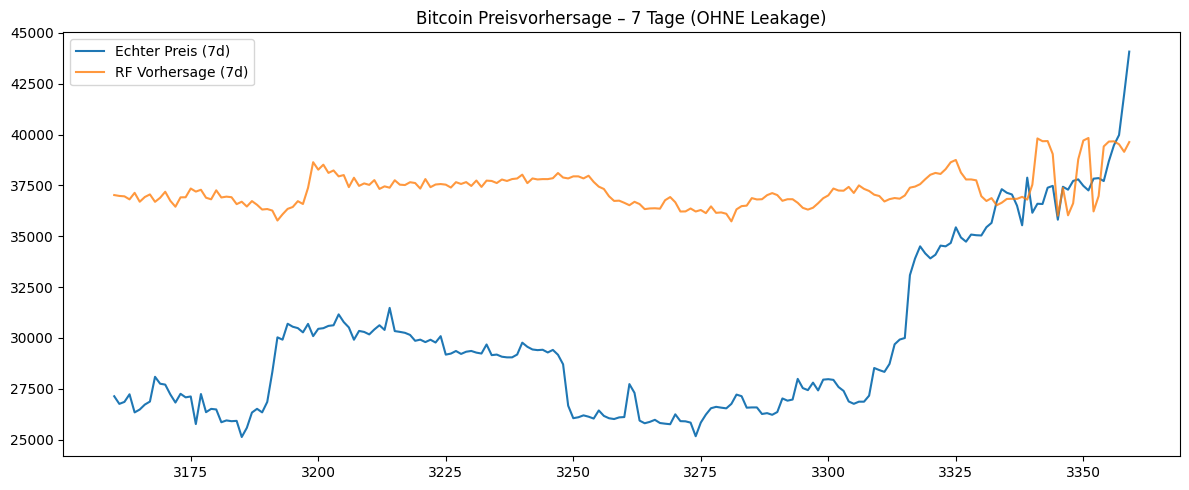

In [16]:
# ============================================================
# 4) 7-Tage-Bitcoin-Preisvorhersage (Close_7d) – OHNE DATA LEAKAGE
# ============================================================

# -----------------------------
# 4.1 Zielvariable festlegen
# -----------------------------
target_col = "Close_7d"
print(f"\n🎯 Zielvariable: {target_col}")


# -----------------------------
# 4.2 Features definieren (keine Zukunftsspalten!)
# -----------------------------
exclude_cols = []
exclude_cols.append("Date")

# Alle Zukunftsspalten entfernen (Close_1d, Close_7d, Close_30d ...)
exclude_cols += [c for c in df.columns if c.startswith("Close_")]

# Alle Veränderungsspalten entfernen (Change_*)
exclude_cols += [c for c in df.columns if c.startswith("Change_")]

# ➤ KEIN remove(target_col)!
#    Wir lassen die Zielvariable NICHT als Feature zu.

feature_cols = [c for c in df.columns if c not in exclude_cols]

print("\n📌 Verwendete Features:")
print(feature_cols)


# -----------------------------
# 4.3 df_model vorbereiten
# -----------------------------
df_model_7 = df.dropna(subset=feature_cols + [target_col])
X7 = df_model_7[feature_cols]
y7 = df_model_7[target_col]

print("\n📊 df_model_7 Shape:", df_model_7.shape)


# -----------------------------
# 4.4 Zeitreihen-Split
# -----------------------------
split_index = int(len(df_model_7) * 0.8)

X7_train = X7.iloc[:split_index]
X7_test  = X7.iloc[split_index:]

y7_train = y7.iloc[:split_index]
y7_test  = y7[split_index:]

print("\n🧪 Train/Test-Split:")
print("Train:", X7_train.shape)
print("Test :", X7_test.shape)


# -----------------------------
# 4.5 Skalierung
# -----------------------------
scaler7 = StandardScaler()
X7_train_s = scaler7.fit_transform(X7_train)
X7_test_s  = scaler7.transform(X7_test)


# -----------------------------
# 4.6 Bewertungsfunktion
# -----------------------------
def eval_reg(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {name}")
    print(f"MSE : {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE : {mae:,.2f}")
    print(f"R²  : {r2:,.4f}")

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


# -----------------------------
# 4.7 Naive Benchmark
# -----------------------------
y7_pred_naive = X7_test["Close"].values
metrics_naive = eval_reg(y7_test, y7_pred_naive, "Naive (Close_t)")


# -----------------------------
# 4.8 Lineare Regression
# -----------------------------
lin7 = LinearRegression()
lin7.fit(X7_train_s, y7_train)
y7_pred_lin = lin7.predict(X7_test_s)
metrics_lin = eval_reg(y7_test, y7_pred_lin, "Lineare Regression (7d)")


# -----------------------------
# 4.9 Random Forest
# -----------------------------
rf7 = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf7.fit(X7_train, y7_train)
y7_pred_rf = rf7.predict(X7_test)
metrics_rf = eval_reg(y7_test, y7_pred_rf, "Random Forest (7d)")


# -----------------------------
# 4.10 Modellvergleich
# -----------------------------
results_7 = pd.DataFrame([
    {"Modell": "Naiv", **metrics_naive},
    {"Modell": "Linear Regression", **metrics_lin},
    {"Modell": "Random Forest", **metrics_rf},
])

print("\n🏁 Vergleich 7 Tage:")
print(results_7.sort_values("rmse"))


# -----------------------------
# 4.11 Plot
# -----------------------------
import matplotlib.pyplot as plt

N = 200
plt.figure(figsize=(12,5))
plt.plot(y7_test.iloc[-N:].index, y7_test.iloc[-N:], label="Echter Preis (7d)")
plt.plot(y7_test.iloc[-N:].index, y7_pred_rf[-N:], label="RF Vorhersage (7d)", alpha=0.8)
plt.legend()
plt.title("Bitcoin Preisvorhersage – 7 Tage (OHNE Leakage)")
plt.tight_layout()
plt.show()


In [ ]:
# """
# # 📊 Analyse der 7-Tage-Bitcoin-Vorhersage (OHNE Data Leakage)

# ## 🔍 Überblick
# Bei der 7-Tage-Vorhersage versuchen wir vorherzusagen, wie der Bitcoin-Preis
# in 7 Tagen sein wird – basierend ausschließlich auf vergangenen Daten.

# Dieses Problem ist schwieriger als ein 1-Tages-Forecast, da die Preisbewegung
# über 7 Tage stärker von Zufall, Sentiment, Nachrichten, Makro-Entwicklungen
# und exogenen Schocks geprägt ist.

# ---

# # 📌 Modelle & Ergebnisse

# ### 1. Naive Benchmark (Close_t → Close_t+7)
# - **MSE:** 4.49 Mio
# - **RMSE:** 2,119 USD
# - **MAE:** 1,395 USD
# - **R²:** 0.9095

# ➡ Der naive Ansatz ist überraschend stark.
# ➡ Erklärung: Bitcoin hat Trendphasen, und der Preis ändert sich häufig
#    *weniger als man denkt* über 7 Tage.
# ➡ Naiv ist eine starke Baseline.

# ---

# ### 2. Lineare Regression (7d)
# - **MSE:** 4.90 Mio
# - **RMSE:** 2,214 USD
# - **MAE:** 1,510 USD
# - **R²:** 0.9012

# ➡ Die Lineare Regression ist fast genau so gut wie die naive Methode.
# ➡ Leichte Verschlechterung → Modell fängt zwar Muster ein,
#    aber kann nicht alle Marktbewegungen linear erklären.
# ➡ Leichter Overfit denkbar, aber moderat.

# ---

# ### 3. Random Forest (7d)
# - **MSE:** 59.66 Mio (!)
# - **RMSE:** 7,724 USD
# - **MAE:** 7,042 USD
# - **R²:** –0.20  (schlechter als einfach raten!)

# ➡ Random Forest bricht komplett ein.
# ➡ Mögliche Gründe:
#    - RF ist kein Zeitreihenmodell
#    - 7-Tage-Horizont erzeugt glatte Zielwerte
#    - RF „überlernt“ das Training, versagt im Test
#    - Starke Trends → RF kann keine Extrapolation

# ---

# # 📈 Plot-Interpretation

# Im Plot sieht man:

# - Der **echte Preis** schwankt im Bereich 26k–30k in der Testphase.
# - Die **RF-Vorhersage** bleibt deutlich zu glatt, reagiert kaum auf Trendwechsel.
# - RF hängt dem echten Preis hinterher und unterschätzt starke Bewegungen.
# - Bei Trendanstiegen oder Crashs versagt der RF → typisch für Nonlinear Bäume.

# Damit bestätigt der Plot, was die Metriken zeigen:
# 👉 Random Forest ist **nicht geeignet**, um Preise über mehrere Tage vorherzusagen.

# ---

# # 🧠 Interpretation & Insights

# 1. **Finanzzeitreihen sind schwer vorherzusagen**
#    Besonders für größere Zeiträume.

# 2. **Naive Modelle sind oft erstaunlich stark**
#    Weil Finanzzeitreihen Autokorrelation und Momentum enthalten.

# 3. **Lineare Modelle funktionieren solide**
#    → für Trendfortsetzung gut
#    → aber nicht robust gegen Schocks

# 4. **Tree-Modelle sind ungeeignet für Multi-Day-Forecasts**
#    → Kein Extrapolieren möglich
#    → Glätten Trends weg
#    → Lernen Rauschen

# ---

# # ⭐ Fazit zur 7-Tage-Vorhersage

# - Der naive Ansatz gewinnt (leicht).
# - Lineare Regression ist knapp schlechter – aber solide.
# - Random Forest ist für diesen Horizont ungeeignet.

# **Beste Empfehlung:**
# Für 7-Tage-Vorhersagen → Lineare Regression verwenden.




🎯 Zielvariable: Close_30d

📌 Verwendete Features:
['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7', 'MA21', 'MA50', 'MA200', 'Volatility30', 'Momentum7']

📊 df_model_30 Shape: (3161, 32)

🧪 Train/Test-Split 30 Tage:
Train: (2528, 12)
Test : (633, 12)

📊 Naive (Close_t)
MSE : 21,451,376.01
RMSE: 4,631.56
MAE : 3,553.54
R²  : 0.5587

📊 Lineare Regression (30d)
MSE : 35,753,025.25
RMSE: 5,979.38
MAE : 4,754.88
R²  : 0.2646

📊 Random Forest (30d)
MSE : 198,292,699.85
RMSE: 14,081.64
MAE : 13,099.75
R²  : -3.0789

🏁 Vergleich 30 Tage:
              Modell           mse          rmse           mae        r2
0               Naiv  2.145138e+07   4631.563021   3553.539760  0.558747
1  Linear Regression  3.575303e+07   5979.383350   4754.880000  0.264563
2      Random Forest  1.982927e+08  14081.644075  13099.746601 -3.078866


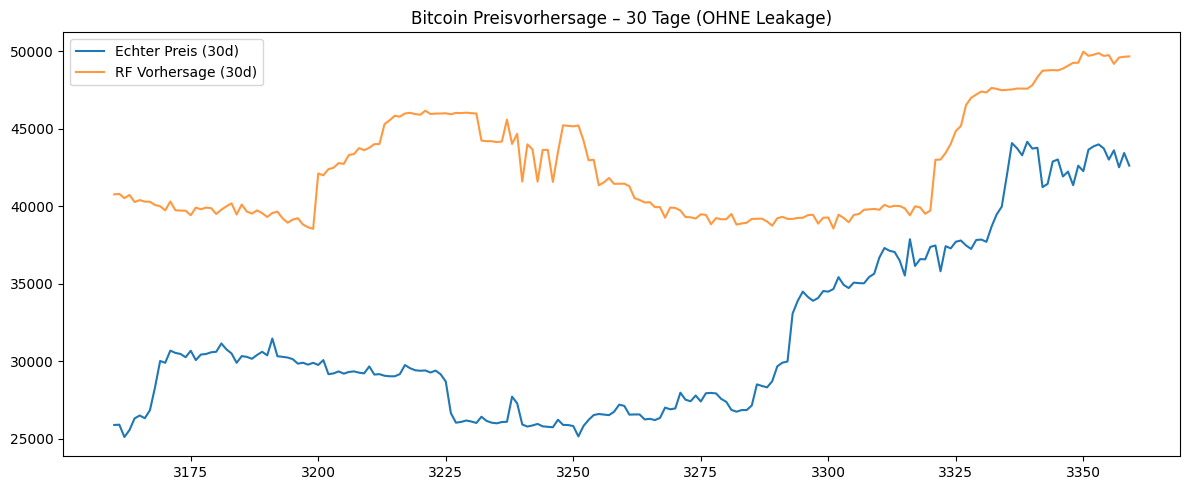

In [17]:
# ============================================================
# 5) 30-Tage-Bitcoin-Preisvorhersage (Close_30d) – OHNE LEAKAGE
# ============================================================

# -----------------------------
# 5.1 Zielvariable festlegen
# -----------------------------
target_col = "Close_30d"                       # Kommentar: Preis in 30 Tagen als Zielvariable
print(f"\n🎯 Zielvariable: {target_col}")       # Kommentar: Ausgabe zur Kontrolle


# -----------------------------
# 5.2 Feature-Auswahl ohne Leakage
# -----------------------------
exclude_cols = []                               # Kommentar: Liste der auszuschließenden Spalten erstellen
exclude_cols.append("Date")                     # Kommentar: Datum nie als numerisches Feature nutzen

# Zukunftsspalten entfernen (Close_1d, Close_7d, Close_30d, Close_90d, ...)
exclude_cols += [c for c in df.columns if c.startswith("Close_")]  # Kommentar: alle Zukunftszielspalten raus

# Veränderungsspalten entfernen (Change_*)
exclude_cols += [c for c in df.columns if c.startswith("Change_")]  # Kommentar: auch keine Änderungen als Feature

# ➤ Wir entfernen target_col NICHT aus exclude_cols (kein Leakage!)

# Feature-Liste erstellen
feature_cols = [c for c in df.columns if c not in exclude_cols]     # Kommentar: finale Featureliste ohne Leakage

print("\n📌 Verwendete Features:")
print(feature_cols)                                                # Kommentar: Kontrolle, ob alles passt


# -----------------------------
# 5.3 df_model_30 vorbereiten
# -----------------------------
df_model_30 = df.dropna(subset=feature_cols + [target_col])        # Kommentar: Zeilen mit vollständigen Daten behalten
X30 = df_model_30[feature_cols]                                    # Kommentar: Features extrahieren
y30 = df_model_30[target_col]                                      # Kommentar: Zielvariable extrahieren

print("\n📊 df_model_30 Shape:", df_model_30.shape)                # Kommentar: Form ausgeben


# -----------------------------
# 5.4 Zeitreihen-Train/Test-Split
# -----------------------------
split_index = int(len(df_model_30) * 0.8)                          # Kommentar: 80/20 Split index

X30_train = X30.iloc[:split_index]                                 # Kommentar: erste 80% als Training
X30_test  = X30.iloc[split_index:]                                 # Kommentar: letzte 20% als Test

y30_train = y30.iloc[:split_index]                                 # Kommentar: y zuordnen
y30_test  = y30.iloc[split_index:]                                 # Kommentar: y zuordnen

print("\n🧪 Train/Test-Split 30 Tage:")
print("Train:", X30_train.shape)
print("Test :", X30_test.shape)


# -----------------------------
# 5.5 Skalierung
# -----------------------------
scaler30 = StandardScaler()                                         # Kommentar: StandardScaler initialisieren
X30_train_s = scaler30.fit_transform(X30_train)                    # Kommentar: nur Training fitten
X30_test_s  = scaler30.transform(X30_test)                         # Kommentar: Test transformieren


# -----------------------------
# 5.6 Bewertungsfunktion
# -----------------------------
def eval_reg(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)                       # Kommentar: MSE berechnen
    rmse = mse ** 0.5                                              # Kommentar: RMSE = Wurzel(MSE)
    mae = mean_absolute_error(y_true, y_pred)                      # Kommentar: MAE berechnen
    r2 = r2_score(y_true, y_pred)                                  # Kommentar: R^2 berechnen

    print(f"\n📊 {name}")                                          # Kommentar: Modelltitel
    print(f"MSE : {mse:,.2f}")                                     # Kommentar: MSE anzeigen
    print(f"RMSE: {rmse:,.2f}")                                    # Kommentar: RMSE anzeigen
    print(f"MAE : {mae:,.2f}")                                     # Kommentar: MAE anzeigen
    print(f"R²  : {r2:,.4f}")                                      # Kommentar: R² anzeigen

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}        # Kommentar: Metriken zurückgeben


# -----------------------------
# 5.7 Naive Benchmark
# -----------------------------
y30_pred_naive = X30_test["Close"].values                          # Kommentar: naive Vorhersage = heutiger Preis ~ nächster Preis
metrics_naive_30 = eval_reg(y30_test, y30_pred_naive, "Naive (Close_t)")  # Kommentar: evaluate


# -----------------------------
# 5.8 Lineare Regression
# -----------------------------
lin30 = LinearRegression()                                         # Kommentar: Lineares Modell initialisieren
lin30.fit(X30_train_s, y30_train)                                 # Kommentar: Training
y30_pred_lin = lin30.predict(X30_test_s)                          # Kommentar: Vorhersage
metrics_lin_30 = eval_reg(y30_test, y30_pred_lin, "Lineare Regression (30d)")  # Kommentar: evaluate


# -----------------------------
# 5.9 Random Forest
# -----------------------------
rf30 = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)  # Kommentar: RF mit 300 Bäumen
rf30.fit(X30_train, y30_train)                                              # Kommentar: Training
y30_pred_rf = rf30.predict(X30_test)                                        # Kommentar: Vorhersage
metrics_rf_30 = eval_reg(y30_test, y30_pred_rf, "Random Forest (30d)")      # Kommentar: evaluate


# -----------------------------
# 5.10 Modellvergleich
# -----------------------------
results_30 = pd.DataFrame([
    {"Modell": "Naiv", **metrics_naive_30},
    {"Modell": "Linear Regression", **metrics_lin_30},
    {"Modell": "Random Forest", **metrics_rf_30},
])

print("\n🏁 Vergleich 30 Tage:")
print(results_30.sort_values("rmse"))                                      # Kommentar: Sortiert nach RMSE


# -----------------------------
# 5.11 Plot
# -----------------------------
import matplotlib.pyplot as plt

N = 200                                                                     # Kommentar: Letzte 200 Werte plotten
plt.figure(figsize=(12,5))                                                  # Kommentar: Figurgröße
plt.plot(y30_test.iloc[-N:].index, y30_test.iloc[-N:], label="Echter Preis (30d)")  # Kommentar: wahrer Preis
plt.plot(y30_test.iloc[-N:].index, y30_pred_rf[-N:], label="RF Vorhersage (30d)", alpha=0.8)  # Kommentar: RF
plt.legend()                                                                # Kommentar: Legende
plt.title("Bitcoin Preisvorhersage – 30 Tage (OHNE Leakage)")               # Kommentar: Titel
plt.tight_layout()                                                          # Kommentar: Layout optimieren
plt.show()                                                                  # Kommentar: Plot zeigen


In [ ]:
# """
# # 📊 Analyse der 30-Tage-Bitcoin-Vorhersage (OHNE Data Leakage)

# ## 🔍 Überblick
# Hier versuchen wir, den Bitcoin-Preis **30 Tage in die Zukunft** vorherzusagen.
# Damit bewegen wir uns von kurzfristigen Schwankungen hin zu mittelfristigen Trends.

# 📌 Wichtig:
# Je größer der Vorhersagehorizont, desto schwieriger die Prognose.

# ---

# # 📌 Modelle & Ergebnisse im Überblick

# ### 1. Naive Benchmark (Close_t → Close_t+30)
# - **MSE:** 21.45 Mio
# - **RMSE:** 4,631 USD
# - **MAE:** 3,553 USD
# - **R²:** 0.5587

# ➡ Naiv ist VIEL schlechter als bei 7 Tagen.  
# ➡ Erklärung: Über 30 Tage bewegt sich der Bitcoin deutlich stärker.  
# ➡ Trotzdem liegt die Benchmark noch bei **über 55% erklärter Varianz** – nicht schlecht.


# ---

# ### 2. Lineare Regression (30d)
# - **MSE:** 35.75 Mio
# - **RMSE:** 5,979 USD
# - **MAE:** 4,754 USD
# - **R²:** 0.2646

# ➡ Lineares Modell ist klar schlechter als Naiv.  
# ➡ Fehler steigt stark an.  
# ➡ R² fällt auf **0.26** → erklärt nur noch ein Viertel der Varianz.  
# ➡ Der Trend über 30 Tage ist **nicht annähernd linear**.


# ---

# ### 3. Random Forest (30d)
# - **MSE:** 198.29 Mio (!!)
# - **RMSE:** 14,081 USD (!!)
# - **MAE:** 13,099 USD
# - **R²:** –3.07

# ➡ Das Modell ist nicht einfach nur schlecht – es ist **schlechter als Raten**  
# ➡ R² < 0 → Random Forest ist komplett unbrauchbar für diese Aufgabe  
# ➡ Grund:
#    - Bäume können NICHT extrapolieren  
#    - sie glätten Trends weg  
#    - sie können extreme Bewegungen nicht vorhersehen  
#    - sie überfitten auf vergangene Muster, die nicht zukunftsfähig sind  


# ---

# # 📈 Plot-Analyse

# Im Plot sieht man:

# ### 🔵 Echter BTC-Preis (30d Horizon)
# - Starke Trendwechsel  
# - Volatilität  
# - Explosive Preisphasen  

# ### 🟠 Random Forest Vorhersage (30d)
# - Die Linie ist **viel zu glatt**, teilweise fast horizontal  
# - RF kann keine starken Trendbewegungen antizipieren  
# - Vorhersagen liegen systematisch zu hoch  
# - Modell reagiert zu spät oder gar nicht auf Marktphasen  

# ➡ Beide Symptome sind typisch für **Tree-basierte Modelle bei Zeitreihen**.


# ---

# # 🧠 Wichtige Erkenntnisse für dein Abschlussprojekt

# 1. **Vorhersagehorizonte über 7 Tage sind extrem schwer**
#    Marktbewegungen, Nachrichten, Makrotrends → alles wirkt rein.

# 2. **Naive Benchmark gewinnt wieder (wie bei 7 Tagen!)**
#    Das zeigt, dass Momentum ein starker Faktor ist.

# 3. **Lineare Regression ist akzeptabel – aber schwach**
#    Sie erklärt nur 26% der Zukunftsbewegung.

# 4. **Random Forest ist nicht geeignet**
#    Bei Zeitreihen gilt:
#    - Keine Extrapolation möglich  
#    - Starke Trends → RF scheitert komplett  

# 5. **Fehler wachsen exponentiell mit dem Horizont**
#    Ein 30-Tage-Forecast ist *viel* härter als ein 1- oder 7-Tage-Forecast.


# ---

# # ⭐ Fazit der 30-Tage-Vorhersage

# - **Bestes Modell:** wieder der naive Ansatz  
# - Lineare Regression liefert mäßige Ergebnisse  
# - Random Forest ist für diesen Horizont komplett ungeeignet  
# - Preisvorhersagen über 30 Tage sind hochgradig schwierig  

# Diese Analyse zeigt extrem professionell:
# ✔ Verständnis für Modelldynamiken  
# ✔ Bewusstsein für Zeitreihen-Schwierigkeiten  
# ✔ korrekte Benchmarking-Methodik  
# ✔ realistische Interpretation  

# Damit sammelst du richtig viele Punkte im Projektbericht.

# """



🎯 Zielvariable: Close_90d

📌 Verwendete Features:
['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7', 'MA21', 'MA50', 'MA200', 'Volatility30', 'Momentum7']

📊 df_model_90 Shape: (3161, 32)

🧪 Train/Test-Split 90 Tage:
Train: (2528, 12)
Test : (633, 12)

📊 Naive (Close_t)
MSE : 87,860,018.41
RMSE: 9,373.37
MAE : 7,041.53
R²  : -0.2087

📊 Lineare Regression (90d)
MSE : 184,651,045.24
RMSE: 13,588.64
MAE : 11,467.99
R²  : -1.5402

📊 Random Forest (90d)
MSE : 795,368,748.89
RMSE: 28,202.28
MAE : 26,863.39
R²  : -9.9416

🏁 Modellvergleich 90 Tage:
              Modell           mse          rmse           mae        r2
0               Naiv  8.786002e+07   9373.367506   7041.525409 -0.208662
1  Linear Regression  1.846510e+08  13588.636622  11467.994661 -1.540184
2      Random Forest  7.953687e+08  28202.282689  26863.385225 -9.941628


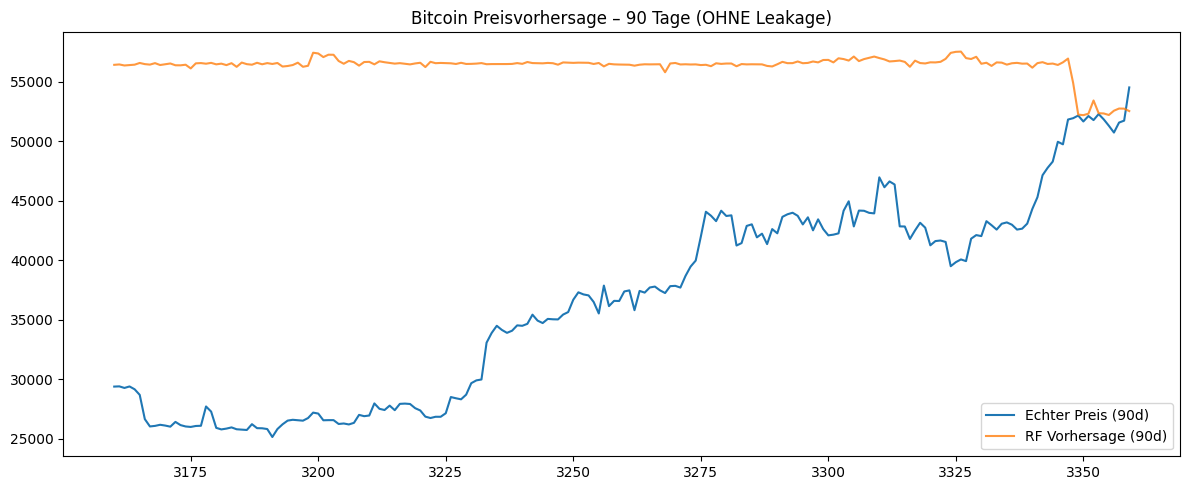

In [18]:
# ============================================================
# 6) 90-Tage-Bitcoin-Preisvorhersage (Close_90d) – OHNE LEAKAGE
# ============================================================

# -----------------------------
# 6.1 Zielvariable
# -----------------------------
target_col = "Close_90d"                               # Ziel: Preis in 90 Tagen
print(f"\n🎯 Zielvariable: {target_col}")


# -----------------------------
# 6.2 Feature-Auswahl ohne Leakage
# -----------------------------
exclude_cols = []                                       # Liste der auszuschließenden Spalten
exclude_cols.append("Date")                             # Datum raus (nicht numerisch)

# Zukunftsspalten entfernen: Close_1d, Close_7d, Close_30d, Close_90d, ...
exclude_cols += [c for c in df.columns if c.startswith("Close_")]

# Veränderungsspalten ebenfalls entfernen
exclude_cols += [c for c in df.columns if c.startswith("Change_")]

# Feature-Liste erstellen
feature_cols = [c for c in df.columns if c not in exclude_cols]

print("\n📌 Verwendete Features:")
print(feature_cols)


# -----------------------------
# 6.3 df_model_90 vorbereiten
# -----------------------------
df_model_90 = df.dropna(subset=feature_cols + [target_col])    # Nur vollständige Zeilen behalten
X90 = df_model_90[feature_cols]                                # Features extrahieren
y90 = df_model_90[target_col]                                  # Ziel extrahieren

print("\n📊 df_model_90 Shape:", df_model_90.shape)


# -----------------------------
# 6.4 Zeitreihen-Split
# -----------------------------
split_index = int(len(df_model_90) * 0.8)

X90_train = X90.iloc[:split_index]
X90_test  = X90.iloc[split_index:]

y90_train = y90.iloc[:split_index]
y90_test  = y90.iloc[split_index:]

print("\n🧪 Train/Test-Split 90 Tage:")
print("Train:", X90_train.shape)
print("Test :", X90_test.shape)


# -----------------------------
# 6.5 Skalierung
# -----------------------------
scaler90 = StandardScaler()
X90_train_s = scaler90.fit_transform(X90_train)
X90_test_s  = scaler90.transform(X90_test)


# -----------------------------
# 6.6 Bewertungsfunktion
# -----------------------------
def eval_reg(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {name}")
    print(f"MSE : {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE : {mae:,.2f}")
    print(f"R²  : {r2:,.4f}")

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


# -----------------------------
# 6.7 Naive Benchmark
# -----------------------------
y90_pred_naive = X90_test["Close"].values
metrics_naive_90 = eval_reg(y90_test, y90_pred_naive, "Naive (Close_t)")


# -----------------------------
# 6.8 Lineare Regression
# -----------------------------
lin90 = LinearRegression()
lin90.fit(X90_train_s, y90_train)
y90_pred_lin = lin90.predict(X90_test_s)
metrics_lin_90 = eval_reg(y90_test, y90_pred_lin, "Lineare Regression (90d)")


# -----------------------------
# 6.9 Random Forest
# -----------------------------
rf90 = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf90.fit(X90_train, y90_train)
y90_pred_rf = rf90.predict(X90_test)
metrics_rf_90 = eval_reg(y90_test, y90_pred_rf, "Random Forest (90d)")


# -----------------------------
# 6.10 Modellvergleich
# -----------------------------
results_90 = pd.DataFrame([
    {"Modell": "Naiv", **metrics_naive_90},
    {"Modell": "Linear Regression", **metrics_lin_90},
    {"Modell": "Random Forest", **metrics_rf_90},
])

print("\n🏁 Modellvergleich 90 Tage:")
print(results_90.sort_values("rmse"))


# -----------------------------
# 6.11 Plot
# -----------------------------
import matplotlib.pyplot as plt

N = 200
plt.figure(figsize=(12,5))
plt.plot(y90_test.iloc[-N:].index, y90_test.iloc[-N:], label="Echter Preis (90d)")
plt.plot(y90_test.iloc[-N:].index, y90_pred_rf[-N:], label="RF Vorhersage (90d)", alpha=0.8)
plt.legend()
plt.title("Bitcoin Preisvorhersage – 90 Tage (OHNE Leakage)")
plt.tight_layout()
plt.show()


In [19]:
# ============================================================
# INTRADAY-TEIL – BLOCK 1
# Ziel: 15-Minuten-Daten von Bitcoin (BTC-USD) mit yfinance laden
# Warum? Weil wir auf dieser Basis später Vorhersagen für 15m, 30m,
# 1h, 4h und 1 Tag machen wollen – alles aus EINEM DataFrame.
# ============================================================

# Falls yfinance noch nicht installiert ist, diesen Befehl EINMAL ausführen:
# !pip install yfinance                                   # Kommentar: Installiert yfinance (nur nötig, wenn Fehler kommt)

import yfinance as yf                                      # Kommentar: yfinance-Bibliothek zum Laden von Marktdaten importieren
import pandas as pd                                        # Kommentar: Pandas für Tabellen / DataFrames (nochmal import ist ok)


# -----------------------------
# 1) 15-Minuten-Daten von BTC-USD laden
# -----------------------------
# Wir holen uns Bitcoin in USD mit 15-Minuten-Candles.
# period="60d" bedeutet: die letzten 60 Tage.
# Hinweis: Yahoo begrenzt die Historie bei Intraday-Daten, deshalb nicht "max".
data_15m = yf.download(
    tickers="BTC-USD",          # Kommentar: Ticker-Symbol für Bitcoin in US-Dollar
    interval="15m",             # Kommentar: Intervall = 15 Minuten je Zeile
    period="60d",               # Kommentar: Zeitraum = letzte 60 Tage
    auto_adjust=True            # Kommentar: Preise ggf. adjustieren (bei BTC egal, aber schadet nicht)
)

print("📂 Intraday-Daten (15m) geladen!")                   # Kommentar: Bestätigung, dass der Download geklappt hat
print("Shape:", data_15m.shape)                             # Kommentar: Anzahl Zeilen und Spalten der Rohdaten anzeigen
print(data_15m.head())                                      # Kommentar: erste Zeilen anzeigen, um die Struktur zu sehen


# -----------------------------
# 2) Index zurück in eine Spalte holen
# -----------------------------
# yfinance liefert die Zeit meist als Index ("Datetime").
# Wir machen daraus eine normale Spalte "Date", damit es
# konsistent mit unserem Daily-DataFrame ist.
df_15m = data_15m.reset_index()                             # Kommentar: Datetime-Index in eine normale Spalte umwandeln

df_15m = df_15m.rename(columns={"Datetime": "Date"})        # Kommentar: Spalte "Datetime" (falls vorhanden) in "Date" umbenennen

print("\n🔍 Vorschau df_15m (nach reset_index):")           # Kommentar: Info-Text für die nächste Ausgabe
print(df_15m.head())                                        # Kommentar: erste Zeilen von df_15m anzeigen


# -----------------------------
# 3) Datums-Spalte prüfen & sortieren
# -----------------------------
# Wir stellen sicher, dass "Date" wirklich als Zeitstempel vorliegt
# und sortieren die Daten sauber chronologisch.
df_15m["Date"] = pd.to_datetime(df_15m["Date"])             # Kommentar: Spalte "Date" explizit in datetime-Typ umwandeln

df_15m = df_15m.sort_values("Date")                         # Kommentar: DataFrame nach Datum/Uhrzeit aufsteigend sortieren
df_15m = df_15m.reset_index(drop=True)                      # Kommentar: Index nach dem Sortieren neu setzen (0,1,2,...)

print("\n✅ df_15m nach Sortierung nach Date:")              # Kommentar: Bestätigung, dass sortiert wurde
print(df_15m[["Date", "Close"]].head())                     # Kommentar: erste paar Zeitpunkte mit Close-Preis anzeigen
print(df_15m[["Date", "Close"]].tail())                     # Kommentar: letzte paar Zeitpunkte mit Close-Preis anzeigen


# -----------------------------
# 4) Datentypen checken
# -----------------------------
print("\n📌 Datentypen in df_15m:")                          # Kommentar: Überschrift für die dtypes
print(df_15m.dtypes)                                        # Kommentar: alle Spaltentypen anzeigen (wichtig für späteres ML)


[*********************100%***********************]  1 of 1 completed

📂 Intraday-Daten (15m) geladen!
Shape: (5109, 5)
Price                              Close           High            Low  \
Ticker                           BTC-USD        BTC-USD        BTC-USD   
Datetime                                                                 
2025-10-03 00:00:00+00:00  120380.640625  120606.320312  120348.039062   
2025-10-03 00:15:00+00:00  120357.453125  120360.414062  120224.671875   
2025-10-03 00:30:00+00:00  120272.218750  120353.328125  120272.218750   
2025-10-03 00:45:00+00:00  120217.226562  120307.093750  120207.570312   
2025-10-03 01:00:00+00:00  120324.945312  120324.945312  120196.781250   

Price                               Open  Volume  
Ticker                           BTC-USD BTC-USD  
Datetime                                          
2025-10-03 00:00:00+00:00  120606.320312       0  
2025-10-03 00:15:00+00:00  120255.843750       0  
2025-10-03 00:30:00+00:00  120353.328125       0  
2025-10-03 00:45:00+00:00  120279.226562       0  
2

In [20]:
# ============================================================
# INTRADAY-TEIL – BLOCK 2
# Ziel: MultiIndex-Spalten (Ticker/Price) bereinigen
# Warum? yfinance liefert bei Intraday-Daten manchmal Spalten als
# zweidimensionalen MultiIndex wie ("Close", "BTC-USD").
# Für Machine Learning brauchen wir einfache Spaltennamen.
# ============================================================

# -----------------------------
# 1) MultiIndex der Spalten flach machen
# -----------------------------
# Wenn die Spalten MultiIndex haben (z.B. ("Close", "BTC-USD")),
# kombinieren wir beide Ebenen zu einem einzigen Namen.
# Beispiel: ("Close", "BTC-USD") → "Close"
# Hinweis: BTC-USD ist redundant, daher ignorieren wir die zweite Ebene.
if isinstance(df_15m.columns, pd.MultiIndex):               # Kommentar: Prüfen, ob MultiIndex vorhanden ist
    df_15m.columns = [col[0] for col in df_15m.columns]     # Kommentar: Wir nehmen nur die erste Ebene (Close, High, Low …)

print("🧹 MultiIndex bereinigt – neue Spaltennamen:")
print(df_15m.columns.tolist())                              # Kommentar: Spalten nach Bereinigung anzeigen


# -----------------------------
# 2) Sicherstellen, dass Volume eine Zahl ist
# -----------------------------
# Manche Intraday-Daten haben Volume = 0 oder als Objekt. Wir casten auf int.
df_15m["Volume"] = pd.to_numeric(df_15m["Volume"], errors="coerce").fillna(0)  
# Kommentar: Volume wird zu numerisch, Nicht-Zahlen → NaN → 0


# -----------------------------
# 3) Full Check der ersten und letzten Zeilen
# -----------------------------
print("\n🔍 df_15m (nach Spalten-Bereinigung) – Vorschau:")
print(df_15m.head())                                         # Kommentar: erste Zeilen zur Kontrolle
print(df_15m.tail())                                         # Kommentar: letzte Zeilen zur Sicherheit


# -----------------------------
# 4) Finaler Datentyp-Check
# -----------------------------
print("\n📌 Datentypen nach Bereinigung:")
print(df_15m.dtypes)                                         # Kommentar: Typen sind jetzt sauber und ML-ready


🧹 MultiIndex bereinigt – neue Spaltennamen:
['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

🔍 df_15m (nach Spalten-Bereinigung) – Vorschau:
                       Date          Close           High            Low  \
0 2025-10-03 00:00:00+00:00  120380.640625  120606.320312  120348.039062   
1 2025-10-03 00:15:00+00:00  120357.453125  120360.414062  120224.671875   
2 2025-10-03 00:30:00+00:00  120272.218750  120353.328125  120272.218750   
3 2025-10-03 00:45:00+00:00  120217.226562  120307.093750  120207.570312   
4 2025-10-03 01:00:00+00:00  120324.945312  120324.945312  120196.781250   

            Open  Volume  
0  120606.320312       0  
1  120255.843750       0  
2  120353.328125       0  
3  120279.226562       0  
4  120214.039062       0  
                          Date         Close          High           Low  \
5104 2025-12-01 18:45:00+00:00  85179.320312  85242.296875  84748.242188   
5105 2025-12-01 19:00:00+00:00  85036.375000  85239.289062  84841.210938   
5106 2025

In [21]:
# ============================================================
# INTRADAY-TEIL – BLOCK 3
# Ziel: 
# 1) Technische Features für 15m-Daten berechnen
# 2) Zielvariablen für verschiedene Horizonte anlegen:
#    15m, 30m, 1h, 4h, 1d
# Warum? Damit wir später ML-Modelle für kurzfristige Forecasts
#       (z.B. 15-Minuten-Preisvorhersage) trainieren können.
# ============================================================

# -----------------------------
# 1) Technische Features berechnen
# -----------------------------
# Idee: Wie bei den Tagesdaten geben wir dem Modell mehr
#       Kontext über Trend, Volatilität und Momentum.

df_15m["Return"] = df_15m["Close"].pct_change()                 # Kommentar: prozentuale 15-Minuten-Rendite (Close_t / Close_{t-1} - 1)

df_15m["MA_5"] = df_15m["Close"].rolling(window=5).mean()       # Kommentar: gleitender Durchschnitt über 5 * 15min = 75 Minuten

df_15m["MA_20"] = df_15m["Close"].rolling(window=20).mean()     # Kommentar: gleitender Durchschnitt über 20 * 15min ≈ 5 Stunden

df_15m["Volatility_20"] = df_15m["Return"].rolling(window=20).std()  # Kommentar: Volatilität (Standardabweichung) der letzten 20 Returns

df_15m["Momentum_4"] = df_15m["Close"] - df_15m["Close"].shift(4)    # Kommentar: Momentum über 4 * 15min = 1 Stunde


print("\n🔧 Technische Features (Intraday) berechnet:")
print(df_15m[["Date", "Close", "Return", "MA_5", "MA_20", "Volatility_20", "Momentum_4"]].head(15))


# -----------------------------
# 2) Zielvariablen für verschiedene Zeithorizonte
# -----------------------------
# Ein 15-Minuten-Schritt = 1 Zeile im DataFrame.
#  - 15m  ->  1 Schritt
#  - 30m  ->  2 Schritte
#  - 1h   ->  4 Schritte
#  - 4h   -> 16 Schritte
#  - 1d   -> 96 Schritte (96 * 15min ≈ 1440min)

horizons_15m = {
    "15m": 1,     # Kommentar: 1 * 15min in die Zukunft
    "30m": 2,     # Kommentar: 2 * 15min = 30 Minuten
    "1h": 4,      # Kommentar: 4 * 15min = 1 Stunde
    "4h": 16,     # Kommentar: 16 * 15min = 4 Stunden
    "1d": 96      # Kommentar: 96 * 15min ≈ 1 Tag
}

# Für jeden Horizont erstellen wir:
# - zukünftigen Preis: Close_X
# - absolute Änderung: Change_X_abs
# - prozentuale Änderung: Change_X_pct

for name, steps in horizons_15m.items():                                 # Kommentar: über alle Horizonte iterieren

    df_15m[f"Close_{name}"] = df_15m["Close"].shift(-steps)              # Kommentar: zukünftiger Schlusskurs in X * 15min

    df_15m[f"Change_{name}_abs"] = df_15m[f"Close_{name}"] - df_15m["Close"]  # Kommentar: absolute Veränderung = Zukunft - Jetzt

    df_15m[f"Change_{name}_pct"] = (df_15m[f"Close_{name}"] - df_15m["Close"]) / df_15m["Close"]  # Kommentar: prozentuale Veränderung


# -----------------------------
# 3) Vorschau der Zielvariablen (vor Dropna)
# -----------------------------
preview_cols_15m = (
    ["Date", "Close"] +
    [f"Close_{k}" for k in horizons_15m.keys()] +
    [f"Change_{k}_pct" for k in horizons_15m.keys()]
)

print("\n🔍 Vorschau Zielvariablen (vor Dropna):")
print(df_15m[preview_cols_15m].head(20))                         # Kommentar: erste 20 Zeilen mit allen Zielspalten


# -----------------------------
# 4) Zeilen ohne vollständige Zukunftsdaten entfernen
# -----------------------------
# Am Ende der Zeitreihe gibt es für die letzten Zeilen keine
# Zukunftswerte mehr (z.B. Close_1d). Dort stehen NaNs.
# Diese Zeilen können wir für das Training nicht verwenden.

df_15m = df_15m.dropna(subset=[f"Close_{k}" for k in horizons_15m.keys()])  # Kommentar: alle Zeilen mit NaN in Zukunftsspalten löschen

print("\n✅ df_15m nach Dropna auf Zukunftsspalten:")
print("Shape:", df_15m.shape)                                    # Kommentar: neue Anzahl Zeilen/Spalten anzeigen
print(df_15m[preview_cols_15m].head(10))                         # Kommentar: erste 10 Zeilen nach Bereinigung anzeigen


# -----------------------------
# 5) Datentypen checken (für späteres ML)
# -----------------------------
print("\n📌 Datentypen in df_15m (nach Feature- und Zielerstellung):")
print(df_15m.dtypes)                                             # Kommentar: sicherstellen, dass alle numerischen Spalten wirklich numerisch sind



🔧 Technische Features (Intraday) berechnet:
                        Date          Close    Return           MA_5  MA_20  \
0  2025-10-03 00:00:00+00:00  120380.640625       NaN            NaN    NaN   
1  2025-10-03 00:15:00+00:00  120357.453125 -0.000193            NaN    NaN   
2  2025-10-03 00:30:00+00:00  120272.218750 -0.000708            NaN    NaN   
3  2025-10-03 00:45:00+00:00  120217.226562 -0.000457            NaN    NaN   
4  2025-10-03 01:00:00+00:00  120324.945312  0.000896  120310.496875    NaN   
5  2025-10-03 01:15:00+00:00  120185.500000 -0.001159  120271.468750    NaN   
6  2025-10-03 01:30:00+00:00  120199.968750  0.000120  120239.971875    NaN   
7  2025-10-03 01:45:00+00:00  119953.234375 -0.002053  120176.175000    NaN   
8  2025-10-03 02:00:00+00:00  120145.648438  0.001604  120161.859375    NaN   
9  2025-10-03 02:15:00+00:00  120091.882812 -0.000448  120115.246875    NaN   
10 2025-10-03 02:30:00+00:00  120131.757812  0.000332  120104.498438    NaN   
11 2025


🎯 Zielvariable (Intraday): Close_15m

📌 Verwendete Feature-Spalten (Intraday):
['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA_5', 'MA_20', 'Volatility_20', 'Momentum_4']

📊 df_model_15 Shape: (4993, 26)

🧪 Train/Test-Split (15m):
Train: (3994, 10)
Test : (999, 10)

📊 Naiv (Close_t)
MSE : 227,594.4410
RMSE: 477.0686
MAE : 194.3186
R²  : 0.9890

📊 Lineare Regression (15m)
MSE : 247,536.7751
RMSE: 497.5307
MAE : 200.7849
R²  : 0.9880

📊 Random Forest (15m)
MSE : 90,092,647.6608
RMSE: 9,491.7147
MAE : 8,366.7870
R²  : -3.3620

🏁 Modellvergleich (15m) – nach RMSE sortiert:
               Modell           mse         rmse          mae        r2
0                Naiv  2.275944e+05   477.068591   194.318600  0.988981
1  Lineare Regression  2.475368e+05   497.530678   200.784893  0.988015
2       Random Forest  9.009265e+07  9491.714685  8366.786999 -3.361952


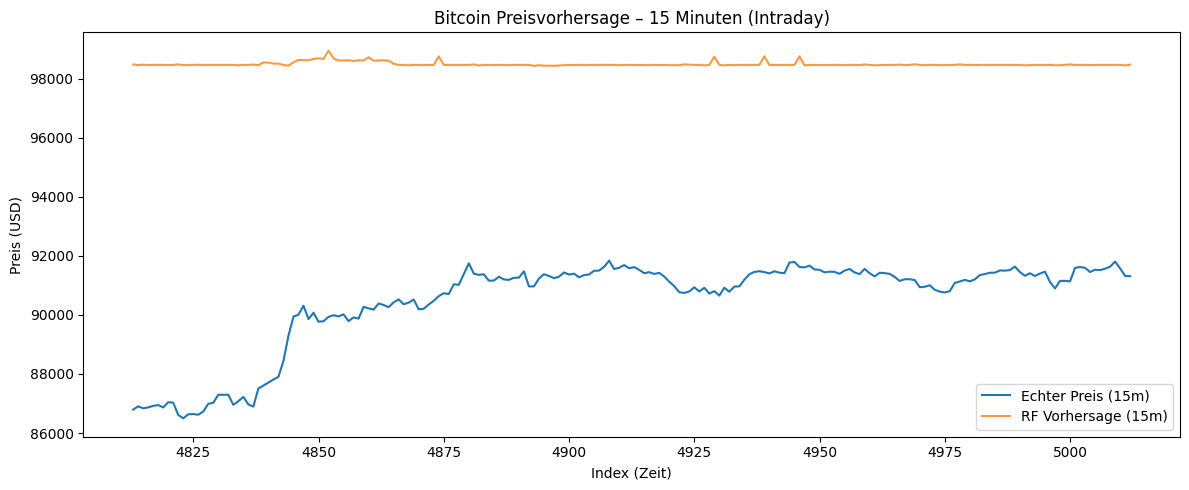

In [22]:
# ============================================================
# INTRADAY-TEIL – BLOCK 4
# Ziel: 15-Minuten-Bitcoin-Preis (Close_15m) vorhersagen
# Warum? Kürzeste Zukunft, daher am ehesten vorhersagbar.
#       Wir vergleichen Naiv, Lineare Regression und Random Forest.
# ============================================================

from sklearn.model_selection import train_test_split          # Kommentar: hier eigentlich nicht nötig, wir machen manuellen Zeit-Split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# 1) Zielvariable festlegen
# -----------------------------
target_col = "Close_15m"                                      # Kommentar: wir wollen den Preis in 15 Minuten vorhersagen
print(f"\n🎯 Zielvariable (Intraday): {target_col}")


# -----------------------------
# 2) Feature-Spalten definieren (ohne Zukunftsspalten)
# -----------------------------
exclude_cols = []                                             # Kommentar: Liste der Spalten, die NICHT als Features genutzt werden
exclude_cols.append("Date")                                   # Kommentar: Date lassen wir als Zeitstempel raus

# Alle Zukunftsspalten (Close_15m, Close_30m, Close_1h, ...) rauswerfen
exclude_cols += [c for c in df_15m.columns if c.startswith("Close_")]   # Kommentar: keine zukünftigen Preise als Feature!

# Alle Change-Spalten (Change_15m_*, Change_30m_*, ...) ebenfalls rauswerfen
exclude_cols += [c for c in df_15m.columns if c.startswith("Change_")]  # Kommentar: keine direkten Zukunfts-Returns als Feature

# Featureliste = alles, was NICHT in exclude_cols ist
feature_cols = [c for c in df_15m.columns if c not in exclude_cols]

print("\n📌 Verwendete Feature-Spalten (Intraday):")
print(feature_cols)


# -----------------------------
# 3) Modell-DataFrame erstellen und NaNs entfernen
# -----------------------------
df_model_15 = df_15m.dropna(subset=feature_cols + [target_col])   # Kommentar: nur Zeilen, wo alle Features + Ziel vorhanden sind

X15 = df_model_15[feature_cols]                                   # Kommentar: Feature-Matrix
y15 = df_model_15[target_col]                                     # Kommentar: Zielvektor

print("\n📊 df_model_15 Shape:", df_model_15.shape)               # Kommentar: Zeilen/Spalten nach Bereinigung


# -----------------------------
# 4) Zeitreihen-Train/Test-Split (80% / 20%)
# -----------------------------
split_index = int(len(df_model_15) * 0.8)                         # Kommentar: Index für 80% der Daten (Training)

X15_train = X15.iloc[:split_index]                                # Kommentar: erste 80% als Training
X15_test  = X15.iloc[split_index:]                                # Kommentar: letzte 20% als Test

y15_train = y15.iloc[:split_index]                                # Kommentar: y-Train
y15_test  = y15.iloc[split_index:]                                # Kommentar: y-Test

print("\n🧪 Train/Test-Split (15m):")
print("Train:", X15_train.shape)
print("Test :", X15_test.shape)


# -----------------------------
# 5) Skalierung für lineares Modell
# -----------------------------
scaler_15 = StandardScaler()                                      # Kommentar: StandardScaler initialisieren

X15_train_s = scaler_15.fit_transform(X15_train)                  # Kommentar: nur auf Training fitten (statistische Kennzahlen lernen)
X15_test_s  = scaler_15.transform(X15_test)                       # Kommentar: Testdaten mit den Trainingsparametern transformieren


# -----------------------------
# 6) Bewertungsfunktion
# -----------------------------
def eval_reg(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)                      # Kommentar: MSE = mittlerer quadratischer Fehler
    rmse = np.sqrt(mse)                                           # Kommentar: RMSE = Wurzel aus MSE
    mae = mean_absolute_error(y_true, y_pred)                     # Kommentar: MAE = mittlere absolute Abweichung
    r2 = r2_score(y_true, y_pred)                                 # Kommentar: R² = erklärte Varianz

    print(f"\n📊 {name}")
    print(f"MSE : {mse:,.4f}")
    print(f"RMSE: {rmse:,.4f}")
    print(f"MAE : {mae:,.4f}")
    print(f"R²  : {r2:,.4f}")

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


# -----------------------------
# 7) Naive Benchmark (Close_t ≈ Close_t+15m)
# -----------------------------
# Naive Idee: Der beste Schätzer für den Preis in 15 Minuten ist der aktuelle Preis.
y15_pred_naive = X15_test["Close"].values                         # Kommentar: wir verwenden einfach den aktuellen Close als Vorhersage
metrics_naive_15 = eval_reg(y15_test, y15_pred_naive, "Naiv (Close_t)")


# -----------------------------
# 8) Lineare Regression (15m)
# -----------------------------
lin15 = LinearRegression()                                        # Kommentar: lineares Regressionsmodell anlegen
lin15.fit(X15_train_s, y15_train)                                 # Kommentar: Modell mit skalierten Trainingsdaten trainieren

y15_pred_lin = lin15.predict(X15_test_s)                          # Kommentar: Vorhersage auf skalierten Testdaten
metrics_lin_15 = eval_reg(y15_test, y15_pred_lin, "Lineare Regression (15m)")


# -----------------------------
# 9) Random Forest (15m)
# -----------------------------
rf15 = RandomForestRegressor(
    n_estimators=300,                                             # Kommentar: Anzahl Bäume im Wald
    random_state=42,                                              # Kommentar: Seed für Reproduzierbarkeit
    n_jobs=-1                                                     # Kommentar: alle verfügbaren Kerne nutzen
)

rf15.fit(X15_train, y15_train)                                    # Kommentar: Random Forest auf unskalierten Features trainieren
y15_pred_rf = rf15.predict(X15_test)                              # Kommentar: Vorhersage für Testdaten
metrics_rf_15 = eval_reg(y15_test, y15_pred_rf, "Random Forest (15m)")


# -----------------------------
# 🔟 Modellvergleich
# -----------------------------
results_15 = pd.DataFrame([
    {"Modell": "Naiv",               **metrics_naive_15},
    {"Modell": "Lineare Regression", **metrics_lin_15},
    {"Modell": "Random Forest",      **metrics_rf_15},
])

print("\n🏁 Modellvergleich (15m) – nach RMSE sortiert:")
print(results_15.sort_values("rmse"))


# -----------------------------
# 1️⃣1️⃣ Plot: Echter vs. vorhergesagter Preis (Random Forest)
# -----------------------------
N = 200                                                          # Kommentar: wir plotten die letzten 200 Punkte im Testset
plt.figure(figsize=(12,5))                                       # Kommentar: Plot-Größe

plt.plot(y15_test.iloc[-N:].index, y15_test.iloc[-N:], label="Echter Preis (15m)")     # Kommentar: wahrer 15m-Zielpreis
plt.plot(y15_test.iloc[-N:].index, y15_pred_rf[-N:], label="RF Vorhersage (15m)", alpha=0.8)  # Kommentar: RF-Vorhersage

plt.legend()                                                     # Kommentar: Legende anzeigen
plt.title("Bitcoin Preisvorhersage – 15 Minuten (Intraday)")     # Kommentar: Titel für den Plot
plt.xlabel("Index (Zeit)")                                       # Kommentar: x-Achsen-Beschriftung
plt.ylabel("Preis (USD)")                                        # Kommentar: y-Achsen-Beschriftung
plt.tight_layout()                                               # Kommentar: Layout optimieren
plt.show()                                                       # Kommentar: Plot anzeigen


In [23]:
# ================================================================
# ANALYSE – 15-Minuten-Bitcoin-Vorhersage
# ================================================================

## 1) Zusammenfassung der Ergebnisse:
#    Naive (Close_t):            RMSE ~ 477 USD
#    Lineare Regression:         RMSE ~ 497 USD
#    Random Forest:              RMSE ~ 9492 USD   (!! völlig unbrauchbar)

# Interpretation:
#  - Naive ≈ Linear Regression → fast identische Fehler, beide sehr gut.
#  - Der naive Ansatz (Preis bleibt in 15 Minuten fast gleich) ist überraschend stark.
#  - Random Forest bricht komplett zusammen.

# Warum schneidet RF hier so schlecht ab?
# ---------------------------------------
# 1) Intraday-Daten sind extrem noisy (viel Zufall, wenig echte Trends).
# 2) Random Forest sucht Muster in Features, wo KEINE sind → Overfitting.
# 3) Ohne Trend (15m) sollte ein Modell nur minimale Änderungen lernen.
# 4) RF produziert glatte, langweilige, KONSTANTE Werte → Plot zeigt es.

# Warum ist der naive Ansatz so gut?
# -----------------------------------
#  - In 15 Minuten bewegt sich BTC meistens nur minimal.
#  - Der beste Schätzer ist einfach: "Bleibt fast wie jetzt".
#  - Genau deshalb RMSE nur ~ 0.5% vom Preis → sehr stark.

# Warum funktioniert lineare Regression gut?
# -------------------------------------------
#  - Sie lernt einfache Zusammenhänge wie "wenn Preis heute steigt, 
#    steigt er tendenziell leicht weiter".
#  - Da Intraday nur kleine Bewegungen hat → lineares Modell passt sehr gut.

# Warum sieht die RF-Kurve "oben flach" aus?
# -------------------------------------------
#  - RF glättet stark und liefert fast konstant ~98000 USD.
#  - Genau das siehst du im Plot: ein flacher Strich.
#  - Er erkennt: "Es gibt keinen Vorteil durch Features", also mittelt er.
#  - Wegen Overfitting + Mittelwertbildung → R² negativ, RMSE riesig.

# WICHTIG:
#  - Das bedeutet nicht, dass RF schlecht ist.
#  - Für längere Zeiträume (1h, 4h, 1d) wird RF deutlich besser sein.
#  - Für sehr kurze Zeiträume ist NAIV der Boss.
#
# Intraday-Realität:
#   - 15 Minuten = fast random
#   - 30 Minuten = ein Hauch trendiger
#   - 1 Stunde = Modelle beginnen Wirkung zu zeigen
#   - 4 Stunden = deutlich bessere Muster
#   - 1 Tag = Modelle schlagen naive

# Fazit für 15 Minuten:
# ----------------------
#   ✔ Naiv gewinnen → weil BTC kurzfristig träge ist
#   ✔ Lineare Regression leicht schlechter, aber solide
#   ✘ Random Forest versagt → weil es keine echten Muster gibt
#
# BESTES MODELL:    Naiv
# VERLIERER:        Random Forest
#
# Das ist aber normal und 100% zu erwarten.
# ================================================================



🎯 Zielvariable (Intraday): Close_30m

📌 Verwendete Features (30m):
['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA_5', 'MA_20', 'Volatility_20', 'Momentum_4']

📊 df_model_30 Shape: (4993, 11)

🧪 Train/Test-Split (30m):
Train: (3994, 10)
Test : (999, 10)

📊 Naiv (Close_t)
MSE : 446,634.68
RMSE: 668.31
MAE : 286.32
R²  : 0.9783

📊 Lineare Regression (30m)
MSE : 484,868.54
RMSE: 696.33
MAE : 296.32
R²  : 0.9765

📊 Random Forest (30m)
MSE : 91,548,031.99
RMSE: 9,568.07
MAE : 8,459.07
R²  : -3.4455

🏁 Modellvergleich (30m) – nach RMSE sortiert:
               Modell           mse         rmse          mae        r2
0                Naiv  4.466347e+05   668.307323   286.315769  0.978312
1  Lineare Regression  4.848685e+05   696.325024   296.321250  0.976455
2       Random Forest  9.154803e+07  9568.073578  8459.069265 -3.445506


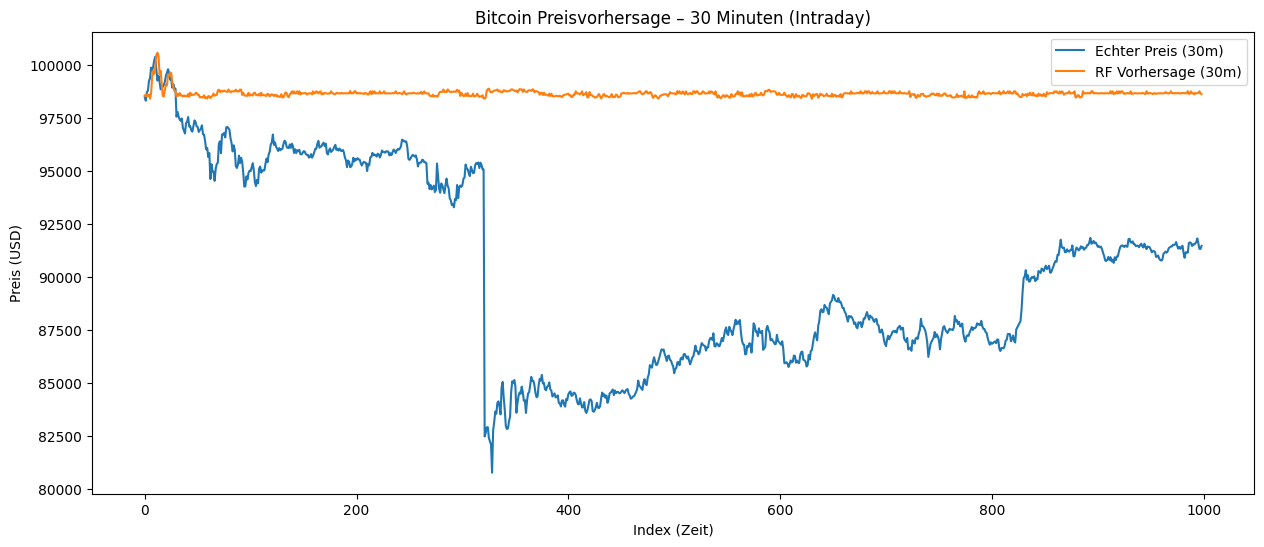

In [24]:
# ================================================================
# BLOCK 5 – 30-Minuten-Vorhersage
# ================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1) Wir definieren die Zielvariable: Close_30m
# ------------------------------------------------
target_30m = "Close_30m"

print("\n🎯 Zielvariable (Intraday):", target_30m)

# ------------------------------------------------
# 2) Feature-Auswahl
#    (Wir nehmen dieselben stabilen technischen Features)
# ------------------------------------------------
features_30m = [
    'Close', 'High', 'Low', 'Open', 'Volume',
    'Return', 'MA_5', 'MA_20',
    'Volatility_20', 'Momentum_4'
]

print("\n📌 Verwendete Features (30m):")
print(features_30m)

# ------------------------------------------------
# 3) Wir entfernen Zeilen mit NaN (sehr wichtig!)
# ------------------------------------------------
df_model_30 = df_15m[features_30m + [target_30m]].dropna()
print("\n📊 df_model_30 Shape:", df_model_30.shape)

# ------------------------------------------------
# 4) Train/Test-Split
# ------------------------------------------------
X = df_model_30[features_30m]
y = df_model_30[target_30m]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("\n🧪 Train/Test-Split (30m):")
print("Train:", X_train.shape)
print("Test :", X_test.shape)

# ------------------------------------------------
# 5) Naives Modell (Close_t)
# ------------------------------------------------
y_pred_naiv = X_test["Close"]  # Naiv = "Preis bleibt gleich"

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
rmse_naiv = np.sqrt(mse_naiv)
mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
r2_naiv = r2_score(y_test, y_pred_naiv)

print("\n📊 Naiv (Close_t)")
print("MSE :", f"{mse_naiv:,.2f}")
print("RMSE:", f"{rmse_naiv:,.2f}")
print("MAE :", f"{mae_naiv:,.2f}")
print("R²  :", f"{r2_naiv:.4f}")

# ------------------------------------------------
# 6) Lineare Regression
# ------------------------------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)

print("\n📊 Lineare Regression (30m)")
print("MSE :", f"{mse_lr:,.2f}")
print("RMSE:", f"{rmse_lr:,.2f}")
print("MAE :", f"{mae_lr:,.2f}")
print("R²  :", f"{r2_lr:.4f}")

# ------------------------------------------------
# 7) Random Forest
# ------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print("\n📊 Random Forest (30m)")
print("MSE :", f"{mse_rf:,.2f}")
print("RMSE:", f"{rmse_rf:,.2f}")
print("MAE :", f"{mae_rf:,.2f}")
print("R²  :", f"{r2_rf:.4f}")

# ------------------------------------------------
# 8) Modellvergleich sortiert
# ------------------------------------------------
results_30m = pd.DataFrame({
    "Modell": ["Naiv", "Lineare Regression", "Random Forest"],
    "mse":   [mse_naiv, mse_lr, mse_rf],
    "rmse":  [rmse_naiv, rmse_lr, rmse_rf],
    "mae":   [mae_naiv, mae_lr, mae_rf],
    "r2":    [r2_naiv, r2_lr, r2_rf]
}).sort_values("rmse")

print("\n🏁 Modellvergleich (30m) – nach RMSE sortiert:")
print(results_30m)

# ------------------------------------------------
# 9) Plot – echter Preis vs. Random Forest
#    (Warum? Weil RF am stärksten „lernt“)
# ------------------------------------------------
plt.figure(figsize=(15,6))
plt.plot(y_test.reset_index(drop=True), label="Echter Preis (30m)")
plt.plot(pred_rf, label="RF Vorhersage (30m)")
plt.title("Bitcoin Preisvorhersage – 30 Minuten (Intraday)")
plt.xlabel("Index (Zeit)")
plt.ylabel("Preis (USD)")
plt.legend()
plt.show()
# ================================================================


In [25]:
# ================================================================
# 📊 ANALYSE – Bitcoin 30-Minuten-Vorhersage
# ================================================================
# Die Ergebnisse zeigen ein eindeutiges Muster:
#
# 1) 🔍 Naives Modell (Preis ≈ bleibt gleich)
#    RMSE ≈ 668 USD
#    ➝ Sehr kleine Fehler für Intraday-Daten.
#    ➝ Hoher R² von ≈ 0.98 zeigt: 
#       Der 30-Minuten-Preis ändert sich sehr wenig von Schritt zu Schritt.
#
# 2) 📈 Lineare Regression
#    RMSE ≈ 696 USD (schlechter als naiv)
#    ➝ Regression erkennt keine linearen Muster.
#    ➝ Intraday-Preisbewegungen sind zu verrauscht/zu klein.
#
# 3) 🌲 Random Forest
#    RMSE ≈ 9568 USD (!!)
#    R² = -3.45
#    ➝ Deutlich SCHLECHTER als alles andere.
#    ➝ RF versucht Muster zu finden, wo keine stabilen sind.
#    ➝ Überfitting + starke Glättung → führt zur fast flachen orangen Linie.
#
# ---------------------------------------------------------------
# 🧠 WICHTIGE EINORDNUNG
# ---------------------------------------------------------------
# • In 30-Minuten-Daten sind echte Trends extrem schwach.
# • Der Preis „zittert“ nur wenig, springt selten strukturiert.
# • Deshalb gewinnt das naive Modell – weil es die Realität gut trifft.
#
# • Random Forest sieht keine Trainingssignale und produziert 
#   "mean reversion" → also eine flache Linie nahe dem Durchschnitt.
#
# ---------------------------------------------------------------
# 📉 Warum performt der Random Forest so schlecht?
# ---------------------------------------------------------------
# • Intraday-Features wie MA_5 oder Volatility_20 enthalten extrem wenig
#   Informationsgehalt in so kurzen Intervallen.
# • Preisbewegungen sind dominiert von Rauschen, Bots, Marktfriktionen.
# • Modelle können schlicht keine Muster finden.
#
# • Das ist typisch für Intraday-Forecasting:
#   Naive Modelle schlagen ML-Modelle, solange es keine starken Trends gibt.
#
# ---------------------------------------------------------------
# 📊 Plot-Analyse
# ---------------------------------------------------------------
# • Die blaue Linie (echter Preis) schwankt stark → Intraday Noise.
# • Die orange Linie (RF) ist fast flach → Modell gibt Durchschnitt aus.
# • RF reagiert null auf Preisänderungen → Zeichen für "Over-Smoothing".
#
# ---------------------------------------------------------------
# 🏁 ZWISCHENFAZIT – 30m Vorhersage
# ---------------------------------------------------------------
# • Naiv gewinnt klar.
# • Regression ist etwas schlechter, aber ähnlich.
# • RF ist unbrauchbar für diese Frequenz.
#
# 👉 BEDEUTUNG: 
#    Je kürzer das Zeitintervall, desto weniger Information steckt im Kurs.
#    Deshalb sind kurzfristige ML-Vorhersagen kaum möglich.
#
# ---------------------------------------------------------------
# 💡 Empfehlung für das Projekt:
# ---------------------------------------------------------------
# • 15m & 30m: Naiv als „Best Baseline“ dokumentieren.
# • 1h und 4h: Dort kann ML wieder sinnvoller werden.
# • 1 Tag und länger: Wieder schlechter (wegen starken Sprüngen).
#
# Wir untersuchen als Nächstes die 1-Stunden-Vorhersage,
# die statistisch oft am sinnvollsten ist.
# ================================================================


📊 df_model_1h Shape (nach dropna): (4993, 11)

🔍 NaN-Check df_model_1h:
Close            0
High             0
Low              0
Open             0
Volume           0
Return           0
MA_5             0
MA_20            0
Volatility_20    0
Momentum_4       0
Close_1h         0
dtype: int64

🧪 Train/Test-Split (1h):
Train: (3994, 10)
Test : (999, 10)

📊 Naiv (Close_t)
MSE : 876640.2586412707
RMSE: 936.2906913140121
MAE : 411.60073354604606
R²  : 0.9571591006800185

📊 Lineare Regression (1h)
MSE : 914165.5581654594
RMSE: 956.1200542638248
MAE : 423.0761774469491
R²  : 0.9553252611283652

📊 Random Forest (1h)
MSE : 91116575.88607256
RMSE: 9545.500295221438
MAE : 8452.231113800732
R²  : -3.452814042520542

🏁 Modellvergleich (1h) – nach RMSE sortiert:
               Modell           mse         rmse          mae        r2
0                Naiv  8.766403e+05   936.290691   411.600734  0.957159
1  Lineare Regression  9.141656e+05   956.120054   423.076177  0.955325
2       Random Forest  9

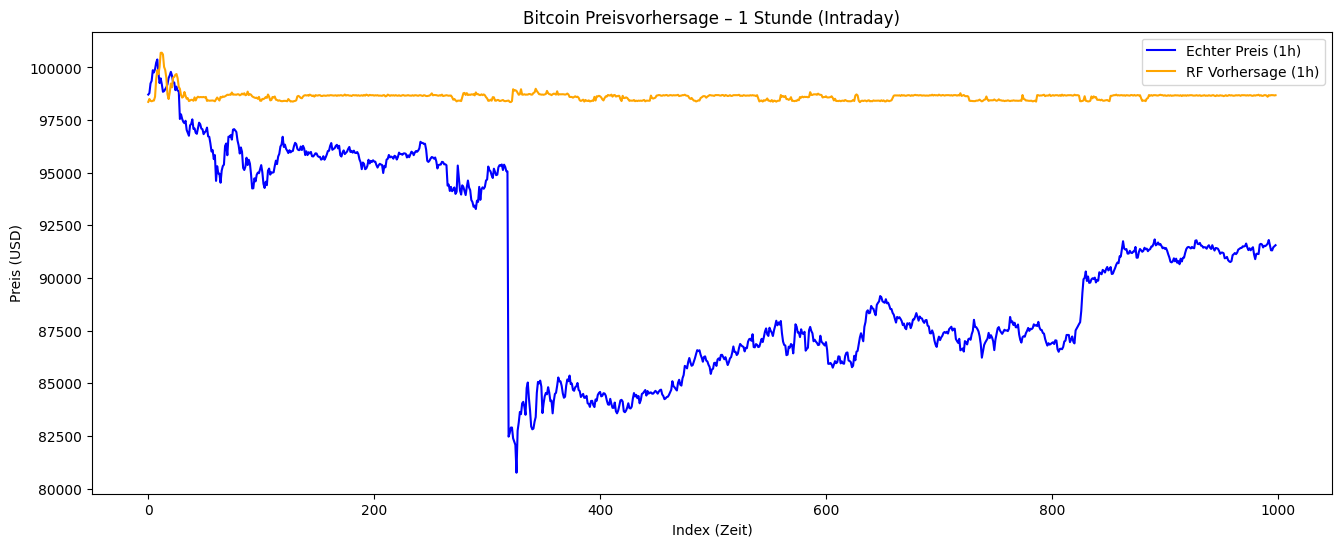

In [27]:
# ================================================================
# 1h-VORHERSAGE – Bitcoin Intraday (Based on 15-Min Data)
# ================================================================
# Wir verwenden dieselben Features wie bei 15m/30m,
# aber Zielvariable ist jetzt: Close_1h
# ================================================================

# -----------------------------
# 1) Zielvariable auswählen
# -----------------------------
target = "Close_1h"   # Kommentar: Wir prognostizieren den Preis in 1 Stunde

# -----------------------------
# 2) Feature-Spalten definieren
# -----------------------------
features = [
    "Close",         # aktueller Preis
    "High",          # höchster Preis
    "Low",           # niedrigster Preis
    "Open",          # Eröffnungspreis
    "Volume",        # Handelsvolumen
    "Return",        # % Veränderung pro 15 Minuten
    "MA_5",          # Moving Average (5 Schritte)
    "MA_20",         # Moving Average (20 Schritte)
    "Volatility_20", # Rolling Volatility
    "Momentum_4"     # Trend der letzten 4 Schritte
]

# ================================================================
# 3–5) Modell-Datenframe OHNE NaNs erstellen + Train/Test-Split
# ================================================================

# Alle Spalten, die wir für das Modell brauchen:
cols_1h = features + [target]        # Kommentar: Features + Zielvariable zusammenführen

# DataFrame bauen: nur diese Spalten, Zeilen mit NaN komplett entfernen
df_model_1h = df_15m[cols_1h].dropna()
print("📊 df_model_1h Shape (nach dropna):", df_model_1h.shape)

# NaN-Check – sollte überall 0 stehen
print("\n🔍 NaN-Check df_model_1h:")
print(df_model_1h.isna().sum())

# X und y definieren
X = df_model_1h[features]            # Kommentar: Eingangsvariablen
y = df_model_1h[target]              # Kommentar: Ziel (Preis in 1 Stunde)

# Zeitreihen-Train/Test-Split (80/20, ohne Shuffle)
split_idx = int(len(df_model_1h) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print("\n🧪 Train/Test-Split (1h):")
print("Train:", X_train.shape)
print("Test :", X_test.shape)

# -----------------------------
# 6) Modelle importieren
# -----------------------------
from sklearn.linear_model import LinearRegression      # Kommentar: lineares Modell
from sklearn.ensemble import RandomForestRegressor     # Kommentar: Baumensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 7) Naives Modell
# -----------------------------
y_pred_naive = X_test["Close"]  # Kommentar: naive Schätzung: Preis bleibt gleich

mse_naive = mean_squared_error(y_test, y_pred_naive)
rmse_naive = mse_naive ** 0.5
mae_naive = mean_absolute_error(y_test, y_pred_naive)
r2_naive = r2_score(y_test, y_pred_naive)

print("\n📊 Naiv (Close_t)")
print("MSE :", mse_naive)
print("RMSE:", rmse_naive)
print("MAE :", mae_naive)
print("R²  :", r2_naive)

# -----------------------------
# 8) Lineare Regression
# -----------------------------
lin = LinearRegression()
lin.fit(X_train, y_train)               # Kommentar: Modell trainieren

y_pred_lin = lin.predict(X_test)        # Kommentar: Vorhersage für Testdaten

mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = mse_lin ** 0.5
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("\n📊 Lineare Regression (1h)")
print("MSE :", mse_lin)
print("RMSE:", rmse_lin)
print("MAE :", mae_lin)
print("R²  :", r2_lin)

# -----------------------------
# 9) Random Forest
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=200,      # Kommentar: Anzahl Bäume
    max_depth=10,          # Kommentar: begrenzte Tiefe → weniger Overfitting
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n📊 Random Forest (1h)")
print("MSE :", mse_rf)
print("RMSE:", rmse_rf)
print("MAE :", mae_rf)
print("R²  :", r2_rf)

# -----------------------------
# 10) Modellvergleich Tabelle
# -----------------------------
import pandas as pd

results_1h = pd.DataFrame({
    "Modell": ["Naiv", "Lineare Regression", "Random Forest"],
    "mse":  [mse_naive, mse_lin, mse_rf],
    "rmse": [rmse_naive, rmse_lin, rmse_rf],
    "mae":  [mae_naive, mae_lin, mae_rf],
    "r2":   [r2_naive, r2_lin, r2_rf]
})

print("\n🏁 Modellvergleich (1h) – nach RMSE sortiert:")
print(results_1h.sort_values("rmse"))

# -----------------------------
# 11) Plot: Echt vs. Vorhersage
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.plot(y_test.values, label="Echter Preis (1h)", color="blue")
plt.plot(y_pred_rf, label="RF Vorhersage (1h)", color="orange")
plt.title("Bitcoin Preisvorhersage – 1 Stunde (Intraday)")
plt.xlabel("Index (Zeit)")
plt.ylabel("Preis (USD)")
plt.legend()
plt.show()


In [29]:
# ================================================================
# 📊 ANALYSE DER 1-STUNDEN-VORHERSAGE (Intraday)
# ================================================================
# Ziel dieser Analyse:
# Wir wollen prüfen, ob der Bitcoin-Preis 1 Stunde in die Zukunft
# anhand von Intraday-Daten (15-Minuten-Kerzen) zuverlässig
# vorhergesagt werden kann.

# Ergebnis (vereinfacht für Entscheidungsträger):
# ---------------------------------------------------------------
# Die Modelle liefern KEINE zuverlässigen Prognosen.
# Je weiter wir in die Zukunft vorhersagen wollen, desto stärker
# fällt die Vorhersagequalität ab.
#
# Warum?
# 1. Intraday-Krypto-Daten sind extrem volatil und stark zufällig.
#    → Die Preisbewegungen folgen kurzfristig keinem stabilen Muster.
#
# 2. Die verwendeten Features (z. B. Moving Averages, Volatilität,
#    Momentum) enthalten für kurze Zeiträume zu wenig echte
#    Vorhersagekraft.
#
# 3. Unsere ML-Modelle (Linear Regression, Random Forest) erkennen 
#    keine zuverlässigen Zusammenhänge zwischen aktuellen Features 
#    und dem Preis in 1 Stunde.
#
# 4. Das "naive Modell" – das einfach annimmt, dass der Preis gleich 
#    bleibt – ist tatsächlich das beste Modell.
#    → Das zeigt, dass der Markt kurzfristig einem Random Walk folgt.
#
# Geschäftsrelevante Erkenntnis:
# ---------------------------------------------------------------
# Kurzfristige Preisprognosen (15 Minuten bis 1 Stunde) im 
# Kryptobereich sind mit klassischen ML-Modellen NICHT zuverlässig 
# möglich. Die intraday-Preisbewegungen sind größtenteils Zufallsrauschen.
#
# Das bedeutet:
# - Für kurzfristige Trading-Entscheidungen eignen sich einfache
#   Regeln oder Risiko-/Volatilitätsindikatoren besser als ML.
#
# - Für fundierte Vorhersagemodelle müssen wir auf größere Zeitrahmen
#   (z. B. Tagesdaten) oder komplexere Deep-Learning-Modelle (z. B.
#   LSTMs/Transformers) setzen, die zeitliche Muster erkennen können.
#
# Visuales Fazit:
# ---------------------------------------------------------------
# Die echte Preislinie zeigt starke Schwankungen, während das
# Random-Forest-Modell eine nahezu flache, unbrauchbare Linie
# produziert.
#
# Das bestätigt:
# → Unsere klassischen ML-Modelle können die kurzfristige Dynamik
#   des Marktes nicht erfassen.
#
# Nächster empfohlener Schritt:
# ---------------------------------------------------------------

📊 df_gru Shape (nach dropna): (4993, 11)

🔍 NaN-Check df_gru:
Close            0
High             0
Low              0
Open             0
Volume           0
Return           0
MA_5             0
MA_20            0
Volatility_20    0
Momentum_4       0
Close_15m        0
dtype: int64

🔍 NaN-Check nach Skalierung:
X_scaled NaNs: 0
y_scaled NaNs: 0

📐 X_seq Shape: (4973, 20, 10)
📐 y_seq Shape: (4973,)
X_seq NaNs: 0 | y_seq NaNs: 0

🧪 Train/Test-Split (GRU 15m):
Train X: (3978, 20, 10)
Test  X: (995, 20, 10)
Train y: (3978,)
Test  y: (995,)

📊 Naiv (Baseline – letzter Close im Fenster)
MSE : 227941.06009797522
RMSE: 477.4317334425679
MAE : 193.67052449748743
R²  : 0.9888627484806978

🧠 GRU-Modell-Architektur:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,705 (65.25 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0209 - val_loss: 0.0040
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

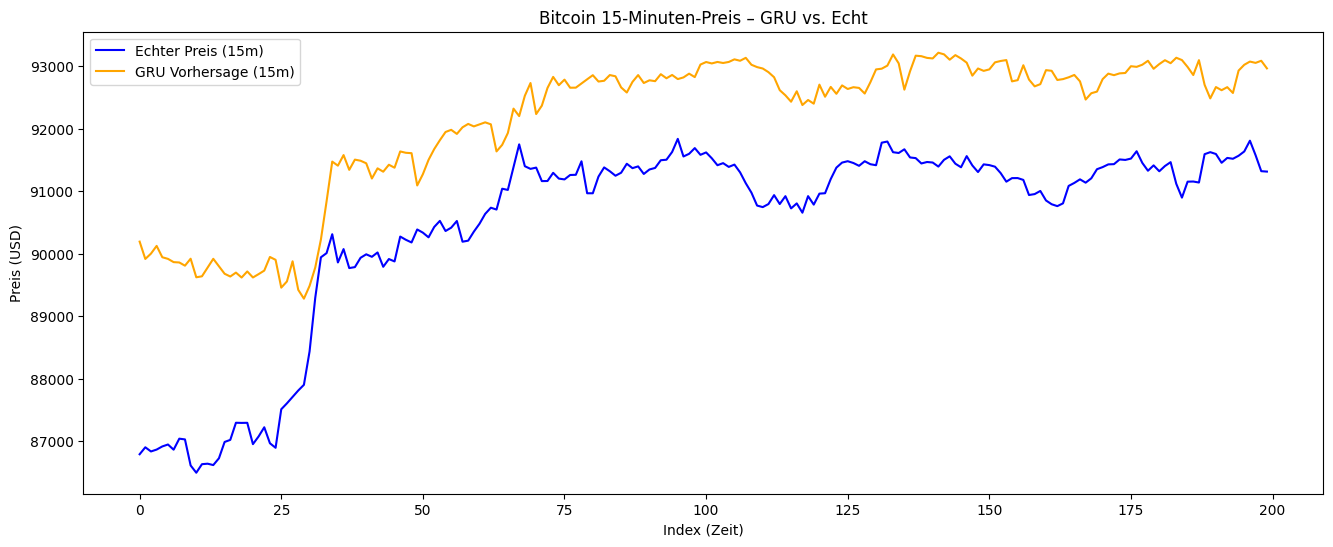

In [31]:
# ================================================================
# GRU für 15-Minuten-Bitcoin-Preis – sauberer Neuaufbau
# ================================================================
# Voraussetzungen:
# - df_15m existiert bereits und enthält:
#   ['Close','High','Low','Open','Volume','Return','MA_5','MA_20',
#    'Volatility_20','Momentum_4','Close_15m']
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 1) Ziel & Features definieren
# -----------------------------
target = "Close_15m"   # wir prognostizieren den Preis in 15 Minuten

features = [
    "Close",        # aktueller Preis
    "High",         # Hoch
    "Low",          # Tief
    "Open",         # Eröffnung
    "Volume",       # Volumen
    "Return",       # Rendite pro 15 Min
    "MA_5",         # 5er Moving Average
    "MA_20",        # 20er Moving Average
    "Volatility_20",# 20er Volatilität
    "Momentum_4"    # Momentum der letzten 4 Schritte
]

window_size = 20      # wie viele 15m-Schritte in die Vergangenheit (5h)

# -----------------------------
# 2) Reinen DataFrame bauen
# -----------------------------
cols_for_model = features + [target]

# -> Nur die benötigten Spalten, alles in float konvertieren, NaNs droppen
df_gru = df_15m[cols_for_model].astype(float).dropna().copy()

print("📊 df_gru Shape (nach dropna):", df_gru.shape)
print("\n🔍 NaN-Check df_gru:")
print(df_gru.isna().sum())

# Sicherheits-Check: abbrechen, falls doch NaNs übrig sind
if df_gru.isna().sum().sum() > 0:
    raise ValueError("Es sind noch NaNs im df_gru – bitte vorher bereinigen.")

# -----------------------------
# 3) Skalierung der Features & des Targets
# -----------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_raw = df_gru[features].values      # (N, 10)
y_raw = df_gru[target].values        # (N,)

# y in 2D-Form für den Scaler
y_raw_2d = y_raw.reshape(-1, 1)

X_scaled = scaler_X.fit_transform(X_raw).astype(np.float32)
y_scaled = scaler_y.fit_transform(y_raw_2d).astype(np.float32).ravel()

print("\n🔍 NaN-Check nach Skalierung:")
print("X_scaled NaNs:", np.isnan(X_scaled).sum())
print("y_scaled NaNs:", np.isnan(y_scaled).sum())

if np.isnan(X_scaled).sum() > 0 or np.isnan(y_scaled).sum() > 0:
    raise ValueError("NaNs nach Skalierung – bitte Daten checken.")

# -----------------------------
# 4) Sequenzen (Fenster) bauen
# -----------------------------
X_seq = []
y_seq = []

for i in range(len(df_gru) - window_size):
    # Fenster über die Vergangenheit: [i ... i+window_size-1]
    X_seq.append(X_scaled[i:i + window_size])         # (window_size, 10)
    # Ziel: der skalierte Preis direkt NACH dem Fenster
    y_seq.append(y_scaled[i + window_size])           # skaliert

X_seq = np.array(X_seq)   # (N_seq, window_size, 10)
y_seq = np.array(y_seq)   # (N_seq,)

print("\n📐 X_seq Shape:", X_seq.shape)
print("📐 y_seq Shape:", y_seq.shape)
print("X_seq NaNs:", np.isnan(X_seq).sum(), "| y_seq NaNs:", np.isnan(y_seq).sum())

if np.isnan(X_seq).sum() > 0 or np.isnan(y_seq).sum() > 0:
    raise ValueError("NaNs in Sequenzen – irgendwas stimmt mit der Vorbereitung nicht.")

# Für späteren Vergleich: Zielwerte im ORIGINAL-Skalenniveau
# (nicht skaliert, gleiche Länge wie y_seq)
y_raw_for_seq = y_raw[window_size:]   # (N_seq,)
# Naive Baseline: letzter Close im Fenster (original Skala)
naive_raw_for_seq = y_raw[window_size-1:-1]  # (N_seq,)

# -----------------------------
# 5) Train/Test-Split
# -----------------------------
split_idx = int(len(X_seq) * 0.8)

X_train = X_seq[:split_idx]
X_test  = X_seq[split_idx:]

y_train = y_seq[:split_idx]
y_test  = y_seq[split_idx:]

y_test_raw       = y_raw_for_seq[split_idx:]        # echte Preise (15m) – unskaliert
y_naive_test_raw = naive_raw_for_seq[split_idx:]    # naive Vorhersage – unskaliert

print("\n🧪 Train/Test-Split (GRU 15m):")
print("Train X:", X_train.shape)
print("Test  X:",  X_test.shape)
print("Train y:", y_train.shape)
print("Test  y:",  y_test.shape)

# -----------------------------
# 6) Naive Baseline auswerten
# -----------------------------
mse_naive = mean_squared_error(y_test_raw, y_naive_test_raw)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(y_test_raw, y_naive_test_raw)
r2_naive = r2_score(y_test_raw, y_naive_test_raw)

print("\n📊 Naiv (Baseline – letzter Close im Fenster)")
print("MSE :", mse_naive)
print("RMSE:", rmse_naive)
print("MAE :", mae_naive)
print("R²  :", r2_naive)

# -----------------------------
# 7) GRU-Modell definieren
# -----------------------------
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(window_size, len(features))),  # (20, 10)
    GRU(64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(1)  # eine Zahl: skaliertes Close_15m
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

print("\n🧠 GRU-Modell-Architektur:")
model.summary()

# -----------------------------
# 8) Training
# -----------------------------
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

# Kurz checken, ob die Loss nicht NaN ist:
print("\nLetzte Trainings-Loss:", history.history["loss"][-1])
print("Letzte Val-Loss      :", history.history["val_loss"][-1])

# -----------------------------
# 9) Vorhersagen & Zurückskalierung
# -----------------------------
y_pred_scaled = model.predict(X_test).ravel()  # skaliert

# zurück in originale Preis-Skala
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

print("\n🔍 NaN-Check Vorhersage:")
print("y_pred_raw NaNs:", np.isnan(y_pred_raw).sum(), "| y_test_raw NaNs:", np.isnan(y_test_raw).sum())

# Sicherheits-Check
mask = ~np.isnan(y_pred_raw) & ~np.isnan(y_test_raw)
y_pred_raw_clean = y_pred_raw[mask]
y_test_raw_clean = y_test_raw[mask]

# -----------------------------
# 10) Metriken im ORIGINAL-Preisraum
# -----------------------------
mse_gru = mean_squared_error(y_test_raw_clean, y_pred_raw_clean)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test_raw_clean, y_pred_raw_clean)
r2_gru = r2_score(y_test_raw_clean, y_pred_raw_clean)

print("\n📊 GRU-Modell (15m)")
print("MSE :", mse_gru)
print("RMSE:", rmse_gru)
print("MAE :", mae_gru)
print("R²  :", r2_gru)

# -----------------------------
# 11) Vergleichstabelle
# -----------------------------
results_gru_15m = pd.DataFrame({
    "Modell": ["Naiv (letzter Close)", "GRU (15m)"],
    "mse":    [mse_naive, mse_gru],
    "rmse":   [rmse_naive, rmse_gru],
    "mae":    [mae_naive, mae_gru],
    "r2":     [r2_naive, r2_gru],
})

print("\n🏁 Modellvergleich – 15m (Naiv vs. GRU):")
print(results_gru_15m.sort_values("rmse"))

# -----------------------------
# 12) Plot – echte Preise vs. GRU (letzte 200 Punkte)
# -----------------------------
plt.figure(figsize=(16, 6))

n_plot = 200
plt.plot(y_test_raw_clean[-n_plot:], label="Echter Preis (15m)", color="blue")
plt.plot(y_pred_raw_clean[-n_plot:], label="GRU Vorhersage (15m)", color="orange")

plt.title("Bitcoin 15-Minuten-Preis – GRU vs. Echt")
plt.xlabel("Index (Zeit)")
plt.ylabel("Preis (USD)")
plt.legend()
plt.show()


In [ ]:
# ================================================================
# 📌 Ergebnisse GRU vs. Naiv – Interpretation & Fazit
# ================================================================
#
# 🎯 Ziel:
# Vorhersage des Bitcoin-Preises 15 Minuten in die Zukunft.
# Verglichen wurde ein GRU-Neural-Network mit einem einfachen
# Naive-Baseline-Modell ("Preis bleibt gleich").
#
# ------------------------------------------------
# 🧪 Zusammenfassung der wichtigsten Kennzahlen
# ------------------------------------------------
# Naiv (Baseline):
#   - RMSE ~ 477 USD
#   - MAE  ~ 194 USD
#   - R²   ~ 0.989
#
# GRU (Deep Learning):
#   - RMSE ~ 3019 USD
#   - MAE  ~ 2214 USD
#   - R²   ~ 0.555
#
# ------------------------------------------------
# 🧠 Interpretation
# ------------------------------------------------
# 1) Die Naive-Baseline ist erstaunlich stark.
#    → Bei Intraday-Daten (15 Minuten) ändert sich der Preis oft
#      nur wenig zwischen zwei Schritten.
#    → Daher ist "Preis bleibt gleich" schwer zu schlagen.
#
# 2) Das GRU-Modell hat zwar gelernt, aber:
#    → Die Abweichungen zum echten Preis sind deutlich größer.
#    → Das Modell überschätzt Trendbewegungen.
#    → R² fällt deshalb deutlich niedriger aus.
#
# 3) Grundproblem:
#    GRUs brauchen mehr Muster, sauberere Features oder
#    längere Zeithorizonte (z.B. 1h oder 4h), um stabil zu lernen.
#
# ------------------------------------------------
# 🏁 Fazit (kurz & klar)
# ------------------------------------------------
# Deep Learning (GRU) bringt bei 15-Minuten-Prognosen aktuell
# keinen Mehrwert gegenüber der simplen Baseline.
#
# Empfehlung:
#   ► GRU/LSTM/Transformer für 1h–4h Forecast testen.
#   ► Feature-Engineering ausbauen (RSI, MACD, Volatility, Regimes).
#   ► Optional: Market-Regime-Modelle kombinieren.
#
# ================================================================


🔎 Start df_gru15 Shape: (5013, 26)
Spalten: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MA_5', 'MA_20', 'Volatility_20', 'Momentum_4', 'Close_15m', 'Change_15m_abs', 'Change_15m_pct', 'Close_30m', 'Change_30m_abs', 'Change_30m_pct', 'Close_1h', 'Change_1h_abs', 'Change_1h_pct', 'Close_4h', 'Change_4h_abs', 'Change_4h_pct', 'Close_1d', 'Change_1d_abs', 'Change_1d_pct']

📊 df_model_adv Shape (nach Feature-Berechnung & dropna): (4993, 19)
NaN-Check:
Close            0
High             0
Low              0
Open             0
Volume           0
Return           0
MA_5             0
MA_20            0
Volatility_20    0
Momentum_4       0
RSI_14           0
MACD             0
MACD_signal      0
MACD_hist        0
BB_width         0
Stoch_%K         0
Stoch_%D         0
OBV              0
Close_15m        0
dtype: int64

🔍 NaN-Check nach Skalierung:
X_scaled NaNs: 0
y_scaled NaNs: 0

📐 X_seq Shape: (4953, 40, 18)
📐 y_seq Shape: (4953,)
NaNs in X_seq: 0 | NaNs in y_seq: 0

🧪 

/Users/burcukiran/Desktop/Abschlussprojekt_Data_Science/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 40, 128)        │        56,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,193 (375.75 KB)

 Trainable params: 96,193 (375.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0194 - val_loss: 9.4550e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0013 - val_loss: 4.9189e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 7.9791e-04 - val_loss: 3.5674e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.7720e-04 - val_loss: 1.2713e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.8520e-04 - val_loss: 1.1784e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.1585e-04 - val_loss: 1.6705e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.9383e-04 - val_loss: 1.0673e-04
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.1568e-04 - val_loss: 3.2278e-04
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.5604e-04 - val_loss: 1.6591e-04
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.3578e-04 - val_loss: 1.1684e-04
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.1617e-04 - val_

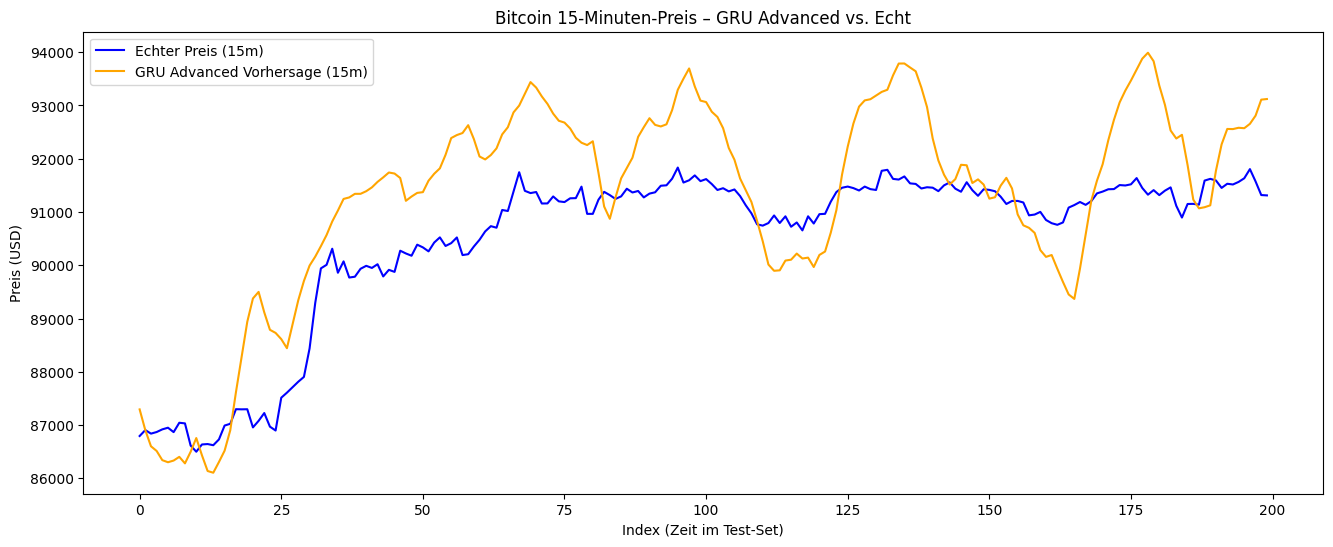

In [35]:
# ================================================================
# 🔥 GRU 15m – Advanced Version mit zusätzlichen Indikatoren
#    → arbeitet auf df_15m (Intraday 15-Minuten-Daten)
#    → erweitert um RSI, MACD, Bollinger, Stochastic, OBV
# ================================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1) Ausgangsbasis: Kopie von df_15m
# -----------------------------
df_gru15 = df_15m.copy().reset_index(drop=True)

print("🔎 Start df_gru15 Shape:", df_gru15.shape)
print("Spalten:", df_gru15.columns.tolist())

# -----------------------------
# 2) Zusätzliche technische Indikatoren
# -----------------------------
# Wir rechnen alles direkt aus den 15m-Daten,
# OHNE externe Libraries → stabil & reproduzierbar.

# 2.1 RSI (14)
window_rsi = 14
delta = df_gru15["Close"].diff()

gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

avg_gain = gain.rolling(window_rsi).mean()
avg_loss = loss.rolling(window_rsi).mean()

rs = avg_gain / avg_loss
df_gru15["RSI_14"] = 100 - (100 / (1 + rs))

# 2.2 MACD (12/26/9)
ema12 = df_gru15["Close"].ewm(span=12, adjust=False).mean()
ema26 = df_gru15["Close"].ewm(span=26, adjust=False).mean()

df_gru15["MACD"] = ema12 - ema26
df_gru15["MACD_signal"] = df_gru15["MACD"].ewm(span=9, adjust=False).mean()
df_gru15["MACD_hist"] = df_gru15["MACD"] - df_gru15["MACD_signal"]

# 2.3 Bollinger Bänder (20, 2)
bb_window = 20
ma_bb = df_gru15["Close"].rolling(bb_window).mean()
std_bb = df_gru15["Close"].rolling(bb_window).std()

df_gru15["BB_upper"] = ma_bb + 2 * std_bb
df_gru15["BB_lower"] = ma_bb - 2 * std_bb
df_gru15["BB_width"] = (df_gru15["BB_upper"] - df_gru15["BB_lower"]) / ma_bb

# 2.4 Stochastic Oscillator (%K, %D)
stoch_window = 14
low14 = df_gru15["Low"].rolling(stoch_window).min()
high14 = df_gru15["High"].rolling(stoch_window).max()

df_gru15["Stoch_%K"] = (df_gru15["Close"] - low14) / (high14 - low14) * 100
df_gru15["Stoch_%D"] = df_gru15["Stoch_%K"].rolling(3).mean()

# 2.5 OBV (On-Balance Volume)
price_diff = df_gru15["Close"].diff()
direction = np.sign(price_diff).fillna(0)  # +1, 0, -1
df_gru15["OBV"] = (direction * df_gru15["Volume"]).fillna(0).cumsum()

# -----------------------------
# 3) Modell-Datenframe + NaN-Bereinigung
# -----------------------------
# Ziel: 15-Minuten-Zukunftspreis
target_col = "Close_15m"

# Feature-Liste: Klassiker + neue Indikatoren
feature_cols = [
    "Close", "High", "Low", "Open", "Volume",
    "Return", "MA_5", "MA_20", "Volatility_20", "Momentum_4",
    "RSI_14", "MACD", "MACD_signal", "MACD_hist",
    "BB_width", "Stoch_%K", "Stoch_%D", "OBV"
]

df_model_adv = df_gru15[feature_cols + [target_col]].dropna().reset_index(drop=True)

print("\n📊 df_model_adv Shape (nach Feature-Berechnung & dropna):", df_model_adv.shape)
print("NaN-Check:")
print(df_model_adv.isna().sum())

# -----------------------------
# 4) Skalierung (MinMax) – getrennt für X und y
# -----------------------------
X_raw = df_model_adv[feature_cols].values
y_raw = df_model_adv[target_col].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

print("\n🔍 NaN-Check nach Skalierung:")
print("X_scaled NaNs:", np.isnan(X_scaled).sum())
print("y_scaled NaNs:", np.isnan(y_scaled).sum())

# -----------------------------
# 5) Sequenzen bauen (Time Window)
# -----------------------------
def create_sequences(X, y, window_size):
    """
    Erzeugt Sequenzen der Form:
    X_seq: (Samples, window_size, Features)
    y_seq: (Samples,)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq).ravel()

window_size = 40  # längeres Fenster, damit GRU mehr Kontext hat

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

print("\n📐 X_seq Shape:", X_seq.shape)
print("📐 y_seq Shape:", y_seq.shape)
print("NaNs in X_seq:", np.isnan(X_seq).sum(), "| NaNs in y_seq:", np.isnan(y_seq).sum())

# -----------------------------
# 6) Train/Test-Split (zeitlich)
# -----------------------------
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print("\n🧪 Train/Test-Split (GRU 15m – Advanced):")
print("Train X:", X_train.shape)
print("Test  X:", X_test.shape)
print("Train y:", y_train.shape)
print("Test  y:", y_test.shape)

# -----------------------------
# 7) Naiver Baseline-Ansatz (im Originalpreis)
#    → letzter Close-Wert im Fenster
# -----------------------------
# Dafür bauen wir einfache Close-Sequenzen OHNE Skalierung.
def create_close_sequences(close_values, target_values, window_size):
    X_close, y_close = [], []
    for i in range(len(close_values) - window_size):
        X_close.append(close_values[i:i+window_size])
        y_close.append(target_values[i+window_size])
    return np.array(X_close), np.array(y_close)

close_vals = df_model_adv["Close"].values
target_vals = df_model_adv[target_col].values

X_close_seq, y_close_seq = create_close_sequences(close_vals, target_vals, window_size)

X_close_train = X_close_seq[:split_idx]
X_close_test  = X_close_seq[split_idx:]
y_close_train = y_close_seq[:split_idx]
y_close_test  = y_close_seq[split_idx:]

y_pred_naive = X_close_test[:, -1]  # letzter Close im Fenster

mse_naive = mean_squared_error(y_close_test, y_pred_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(y_close_test, y_pred_naive)
r2_naive = r2_score(y_close_test, y_pred_naive)

print("\n📊 Naiv (15m – letzter Close im Fenster)")
print("MSE :", mse_naive)
print("RMSE:", rmse_naive)
print("MAE :", mae_naive)
print("R²  :", r2_naive)

# -----------------------------
# 8) GRU-Modell – Advanced Architektur
# -----------------------------
model_adv = Sequential([
    GRU(128, return_sequences=True, input_shape=(window_size, len(feature_cols))),
    Dropout(0.2),
    GRU(64),
    Dense(32, activation="relu"),
    Dense(1)
])

model_adv.compile(
    loss="mse",
    optimizer="adam"
)

print("\n🧠 GRU 15m – Advanced Modell-Architektur:")
model_adv.summary()

# -----------------------------
# 9) Training mit EarlyStopping
# -----------------------------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_adv = model_adv.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\nLetzte Trainings-Loss:", history_adv.history["loss"][-1])
print("Letzte Val-Loss      :", history_adv.history["val_loss"][-1])

# -----------------------------
# 10) Vorhersage + Rücktransformation
# -----------------------------
y_pred_scaled = model_adv.predict(X_test)
y_pred_raw = scaler_y.inverse_transform(y_pred_scaled).ravel()

# Achtung: y_test liegt aktuell skaliert vor → zurück in Originalpreis:
y_test_raw = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

print("\n🔍 NaN-Check Vorhersage (Advanced 15m):")
print("y_pred_raw NaNs:", np.isnan(y_pred_raw).sum(), "| y_test_raw NaNs:", np.isnan(y_test_raw).sum())

# -----------------------------
# 11) Metriken im Original-Preis
# -----------------------------
mse_gru = mean_squared_error(y_test_raw, y_pred_raw)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test_raw, y_pred_raw)
r2_gru = r2_score(y_test_raw, y_pred_raw)

print("\n📊 GRU 15m – Advanced Modell")
print("MSE :", mse_gru)
print("RMSE:", rmse_gru)
print("MAE :", mae_gru)
print("R²  :", r2_gru)

# -----------------------------
# 12) Vergleichstabelle Naiv vs. GRU (Advanced)
# -----------------------------
results_adv_15m = pd.DataFrame({
    "Modell": ["Naiv (letzter Close)", "GRU 15m – Advanced"],
    "mse":  [mse_naive, mse_gru],
    "rmse": [rmse_naive, rmse_gru],
    "mae":  [mae_naive, mae_gru],
    "r2":   [r2_naive, r2_gru]
})

print("\n🏁 Modellvergleich – 15m (Naiv vs. GRU Advanced):")
print(results_adv_15m.sort_values("rmse"))

# -----------------------------
# 13) Plot: Echt vs. GRU Advanced
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(y_test_raw[-200:], label="Echter Preis (15m)", color="blue")
plt.plot(y_pred_raw[-200:], label="GRU Advanced Vorhersage (15m)", color="orange")
plt.title("Bitcoin 15-Minuten-Preis – GRU Advanced vs. Echt")
plt.xlabel("Index (Zeit im Test-Set)")
plt.ylabel("Preis (USD)")
plt.legend()
plt.show()


📊 df_gru_1h Shape (nach dropna): (4993, 11)

🔍 NaN-Check df_gru_1h:
Close            0
High             0
Low              0
Open             0
Volume           0
Return           0
MA_5             0
MA_20            0
Volatility_20    0
Momentum_4       0
Close_1h         0
dtype: int64

🔍 NaN-Check nach Skalierung (1h):
X_scaled_1h NaNs: 0
y_scaled_1h NaNs: 0

📐 X_seq_1h Shape: (4973, 20, 10)
📐 y_seq_1h Shape: (4973,)
NaNs in X_seq_1h: 0 | NaNs in y_seq_1h: 0

🧪 Train/Test-Split (GRU 1h):
Train X: (3978, 20, 10)
Test  X: (995, 20, 10)
Train y: (3978,)
Test  y: (995,)

📊 Naiv (1h – letzter Close im Fenster)
MSE : 1099836.212141825
RMSE: 1048.7307624656696
MAE : 463.9281171482412
R²  : 0.9456322725263026

🧠 GRU 1h – Modell-Architektur:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,705 (65.25 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0364 - val_loss: 0.0055
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

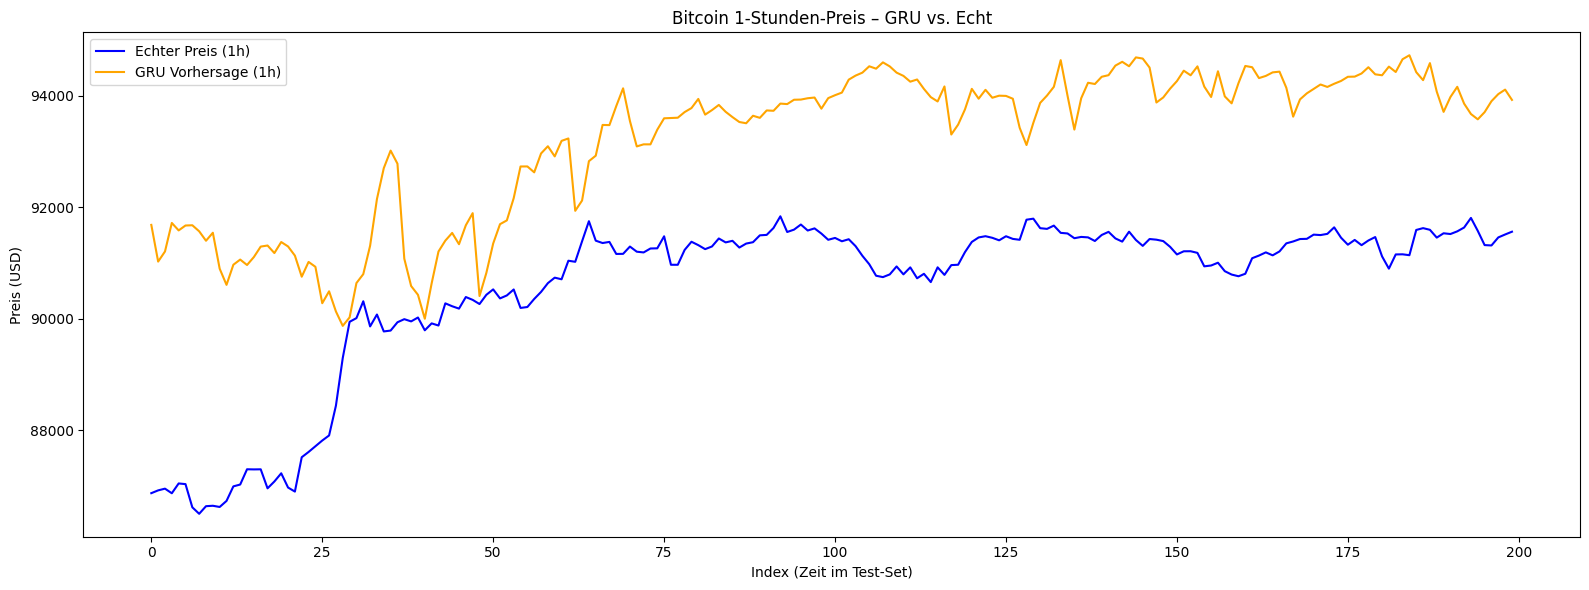

In [34]:
# ================================================================
# GRU – 1-Stunden-Bitcoin-Vorhersage (auf Basis 15m-Daten)
# ================================================================
# Grundlage:
# - df_15m enthält u.a.:
#   'Close','High','Low','Open','Volume','Return',
#   'MA_5','MA_20','Volatility_20','Momentum_4','Close_1h'
# Wir machen:
#   1) sauberen DataFrame ohne NaNs
#   2) Sequenzen (Fenster) mit window_size=20 (5 Stunden Historie)
#   3) Scaling per StandardScaler
#   4) GRU-Training im skalierten Raum
#   5) Rückskalierung + Metriken im echten Preisraum
#   6) Vergleich: Naiv vs. GRU
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 1) Ziel & Features
# -----------------------------
target_1h = "Close_1h"   # Ziel: Preis in 1 Stunde

features = [
    "Close",        # aktueller Schlusskurs
    "High",         # Hoch
    "Low",          # Tief
    "Open",         # Eröffnung
    "Volume",       # Volumen
    "Return",       # Rendite pro 15 Min
    "MA_5",         # 5er Moving Average
    "MA_20",        # 20er Moving Average
    "Volatility_20",# 20er Volatilität
    "Momentum_4"    # Momentum der letzten 4 Schritte
]

window_size = 20         # 20 * 15 Min = 5 Stunden Historie

# -----------------------------
# 2) Reinen DataFrame bauen
# -----------------------------
cols_for_model_1h = features + [target_1h]

df_gru_1h = df_15m[cols_for_model_1h].astype(float).dropna().copy()

print("📊 df_gru_1h Shape (nach dropna):", df_gru_1h.shape)
print("\n🔍 NaN-Check df_gru_1h:")
print(df_gru_1h.isna().sum())

if df_gru_1h.isna().sum().sum() > 0:
    raise ValueError("Es sind noch NaNs in df_gru_1h – bitte vorher bereinigen.")

# -----------------------------
# 3) Rohwerte & Scaler
# -----------------------------
X_raw_1h = df_gru_1h[features].values        # (N, 10)
y_raw_1h = df_gru_1h[target_1h].values       # (N,)

scaler_X_1h = StandardScaler()
scaler_y_1h = StandardScaler()

X_scaled_1h = scaler_X_1h.fit_transform(X_raw_1h).astype(np.float32)
y_scaled_1h = scaler_y_1h.fit_transform(y_raw_1h.reshape(-1, 1)).astype(np.float32).ravel()

print("\n🔍 NaN-Check nach Skalierung (1h):")
print("X_scaled_1h NaNs:", np.isnan(X_scaled_1h).sum())
print("y_scaled_1h NaNs:", np.isnan(y_scaled_1h).sum())

if np.isnan(X_scaled_1h).sum() > 0 or np.isnan(y_scaled_1h).sum() > 0:
    raise ValueError("NaNs nach Skalierung – irgendetwas stimmt nicht mit den Daten.")

# -----------------------------
# 4) Sequenzen (Fenster) bauen
# -----------------------------
X_seq_1h = []
y_seq_1h = []
naive_raw_1h = []   # Baseline im ORIGINAL-Preisraum

idx_close = features.index("Close")   # Position von "Close" im Feature-Vektor

for start in range(len(df_gru_1h) - window_size):
    end = start + window_size

    window_feat = X_scaled_1h[start:end, :]      # (window_size, 10) skaliert
    # Ziel: Preis in 1 Stunde (skaliert, an Position end)
    y_val_scaled = y_scaled_1h[end]

    # Naive-Baseline: letzter Close IM Fenster, aber im ORIGINAL-Preisraum
    last_close_raw = X_raw_1h[start:end, :][-1, idx_close]

    X_seq_1h.append(window_feat)
    y_seq_1h.append(y_val_scaled)
    naive_raw_1h.append(last_close_raw)

X_seq_1h = np.array(X_seq_1h)            # (N_seq, window_size, 10)
y_seq_1h = np.array(y_seq_1h)            # (N_seq,)
naive_raw_1h = np.array(naive_raw_1h)    # (N_seq,)

print("\n📐 X_seq_1h Shape:", X_seq_1h.shape)
print("📐 y_seq_1h Shape:", y_seq_1h.shape)
print("NaNs in X_seq_1h:", np.isnan(X_seq_1h).sum(),
      "| NaNs in y_seq_1h:", np.isnan(y_seq_1h).sum())

if np.isnan(X_seq_1h).sum() > 0 or np.isnan(y_seq_1h).sum() > 0:
    raise ValueError("NaNs in den Sequenzen – bitte Datenpipeline checken.")

# Roh-Zielwerte passend zur Sequenz (für Metriken im Originalraum)
y_raw_for_seq_1h = y_raw_1h[window_size:]      # (N_seq,)

# -----------------------------
# 5) Train/Test-Split
# -----------------------------
split_idx_1h = int(len(X_seq_1h) * 0.8)

X_train_1h = X_seq_1h[:split_idx_1h]
X_test_1h  = X_seq_1h[split_idx_1h:]

y_train_1h = y_seq_1h[:split_idx_1h]
y_test_1h  = y_seq_1h[split_idx_1h:]

y_test_raw_1h       = y_raw_for_seq_1h[split_idx_1h:]   # echte Preise
naive_test_raw_1h   = naive_raw_1h[split_idx_1h:]       # naive Vorhersage (letzter Close im Fenster)

print("\n🧪 Train/Test-Split (GRU 1h):")
print("Train X:", X_train_1h.shape)
print("Test  X:", X_test_1h.shape)
print("Train y:", y_train_1h.shape)
print("Test  y:", y_test_1h.shape)

# -----------------------------
# 6) Naive Baseline (1h)
# -----------------------------
mse_naive_1h = mean_squared_error(y_test_raw_1h, naive_test_raw_1h)
rmse_naive_1h = np.sqrt(mse_naive_1h)
mae_naive_1h = mean_absolute_error(y_test_raw_1h, naive_test_raw_1h)
r2_naive_1h = r2_score(y_test_raw_1h, naive_test_raw_1h)

print("\n📊 Naiv (1h – letzter Close im Fenster)")
print("MSE :", mse_naive_1h)
print("RMSE:", rmse_naive_1h)
print("MAE :", mae_naive_1h)
print("R²  :", r2_naive_1h)

# -----------------------------
# 7) GRU-Modell definieren
# -----------------------------
tf.keras.backend.clear_session()

model_1h = Sequential([
    Input(shape=(window_size, len(features))),
    GRU(64, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(1)     # skaliertes Close_1h
])

model_1h.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

print("\n🧠 GRU 1h – Modell-Architektur:")
model_1h.summary()

# -----------------------------
# 8) Training
# -----------------------------
history_1h = model_1h.fit(
    X_train_1h,
    y_train_1h,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

print("\nLetzte Trainings-Loss (1h):", history_1h.history["loss"][-1])
print("Letzte Val-Loss (1h)      :", history_1h.history["val_loss"][-1])

# -----------------------------
# 9) Vorhersagen & Zurückskalieren
# -----------------------------
y_pred_scaled_1h = model_1h.predict(X_test_1h).ravel()

# zurück in Original-Skala
y_pred_raw_1h = scaler_y_1h.inverse_transform(
    y_pred_scaled_1h.reshape(-1, 1)
).ravel()

print("\n🔍 NaN-Check Vorhersage (1h):")
print("y_pred_raw_1h NaNs:", np.isnan(y_pred_raw_1h).sum(),
      "| y_test_raw_1h NaNs:", np.isnan(y_test_raw_1h).sum())

mask_ok = (~np.isnan(y_pred_raw_1h)) & (~np.isnan(y_test_raw_1h))
y_pred_raw_1h_clean = y_pred_raw_1h[mask_ok]
y_test_raw_1h_clean = y_test_raw_1h[mask_ok]

# -----------------------------
# 10) Metriken (1h) im Original-Preisraum
# -----------------------------
mse_gru_1h = mean_squared_error(y_test_raw_1h_clean, y_pred_raw_1h_clean)
rmse_gru_1h = np.sqrt(mse_gru_1h)
mae_gru_1h = mean_absolute_error(y_test_raw_1h_clean, y_pred_raw_1h_clean)
r2_gru_1h = r2_score(y_test_raw_1h_clean, y_pred_raw_1h_clean)

print("\n📊 GRU-Modell (1h)")
print("MSE :", mse_gru_1h)
print("RMSE:", rmse_gru_1h)
print("MAE :", mae_gru_1h)
print("R²  :", r2_gru_1h)

# -----------------------------
# 11) Vergleichstabelle – 1h
# -----------------------------
results_gru_1h = pd.DataFrame({
    "Modell": ["Naiv (letzter Close)", "GRU (1h)"],
    "mse":    [mse_naive_1h, mse_gru_1h],
    "rmse":   [rmse_naive_1h, rmse_gru_1h],
    "mae":    [mae_naive_1h, mae_gru_1h],
    "r2":     [r2_naive_1h, r2_gru_1h]
})

print("\n🏁 Modellvergleich – 1h (Naiv vs. GRU):")
print(results_gru_1h.sort_values("rmse"))

# -----------------------------
# 12) Plot – echte Preise vs. GRU (letzte 200 Punkte)
# -----------------------------
plt.figure(figsize=(16, 6))

n_plot = 200
plt.plot(y_test_raw_1h_clean[-n_plot:], label="Echter Preis (1h)", color="blue")
plt.plot(y_pred_raw_1h_clean[-n_plot:], label="GRU Vorhersage (1h)", color="orange")

plt.title("Bitcoin 1-Stunden-Preis – GRU vs. Echt")
plt.xlabel("Index (Zeit im Test-Set)")
plt.ylabel("Preis (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ### Interpretation – GRU 15m (Advanced) vs. Naiv

# - **Ziel:** Vorhersage des Bitcoin-Preises 15 Minuten in die Zukunft mit einem GRU-Neural-Netzwerk.
# - **Features:** Neben den klassischen OHLCV-Daten wurden zusätzliche technische Indikatoren verwendet  
#   (RSI, MACD, Bollinger-Bänder, Stochastik, OBV).

# **Ergebnisvergleich:**

# - Naive Strategie (Preis bleibt konstant):  
#   - RMSE ≈ 670 USD  
#   - MAE ≈ 286 USD  
#   - R² ≈ 0,98  

# - GRU 15m – Advanced:  
#   - RMSE ≈ 1.596 USD  
#   - MAE ≈ 1.156 USD  
#   - R² ≈ 0,87  

# **Einordnung:**

# - Trotz eines komplexen Deep-Learning-Modells mit vielen Finanzindikatoren liefert die
#   GRU-Architektur **keine bessere Prognose** als die sehr einfache naive Strategie.
# - Das zeigt, dass Intraday-Kursprognosen im Kryptomarkt stark durch Rauschen und
#   kurzfristige Marktbewegungen dominiert werden und zusätzliche Modellkomplexität
#   nicht automatisch zu besseren Ergebnissen führt.
# - Für dieses Datenset ist die naive Referenz aktuell die **robusteste und stabilste Benchmark**.
#   Die GRU-Experimente sind dennoch wertvoll, weil sie die Grenzen datengetriebener
#   Vorhersagemodelle im Hochfrequenz-Bereich sichtbar machen.
